In [11]:
import pandas as pd
import numpy as np
import pyreadr
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch
import yaml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler # maybe something more robust for unseen data?
from typing import Union, Literal, Callable,Iterable
from torch.utils.data import TensorDataset, DataLoader
from functools import partial
from scipy.stats import entropy
from tqdm import tqdm
import optuna



df_train:pd.DataFrame = pyreadr.read_r('datasets/train.rds')[None]

seed = 1

# Data Profiling

In [12]:
# defining functions

def looping_col(func:Callable, df:pd.DataFrame, chart:bool = False) -> pd.DataFrame:
    """I don t want to see too many for loops later

    Apply a column-wise function over a DataFrame.

    If chart=False (default), calls func(df, col) for each column and
    returns a DataFrame assembled from the results (dict of col -> output).
    If chart=True, simply iterates columns and calls func(df, col) for its side effects
    (e.g., plotting/saving charts), returning nothing.
    
    """
    if not chart:
        output = {col: func(df,col) for col in tqdm(df.columns)}
        return pd.DataFrame(output)
    else:
        for col in df.columns:
            func(df,col)

def summary_df(df:pd.DataFrame, col:str) -> int:

    '''
    Compute lightweight summary stats for one column.

    Returns count, missing, % missing, '-1' placeholders, distincts,
    uniqueness ratio, dtype, mode and its share, entropy (Shannon),
    and for numeric quartiles, IQR whiskers, and outlier count/% via the IQR rule.   
    
    '''

    s = df[col]
    #i explicit dropna=True
    Q25 = Q50 = Q75 = lower = upper = out_count = out_pct = None

    # let s get the wiskers
    if pd.api.types.is_numeric_dtype(s):
        Q25 = s.quantile(0.25)
        Q50 = s.quantile(0.5)
        Q75 = s.quantile(0.75)
        IQR = Q75 - Q25
        lower = Q25 - 1.5*IQR
        upper = Q75 + 1.5*IQR
        outliers = s[(s < lower) | (s > upper)]
        out_count = outliers.count()
        out_pct = outliers.count() / s.count() * 100 

    stats = {
        "count": s.count(),
        "missing": s.isna().sum(),
        "missing_pct": s.isna().mean()*100,
        "missing_minus1":sum(((s == -1) | (s == "-1"))),
        "missing_minus1_pct":round(sum(((s == -1) | (s == "-1")))/s.count(),2),
        "nunique": s.nunique(dropna=True),
        'uniqueness_ratio': round(s.nunique(dropna=True)/len(s),2),
        "dtype": str(s.dtype),
        'most_freq': s.value_counts(ascending=False, dropna=True).index[0],
        '%_most_freq': round((s.value_counts(ascending=False, dropna=True).iloc[0]/s.count())*100,2),
        'entropy': entropy(s.dropna().value_counts(normalize=True)),
        "Q25": Q25,
        "Q50": Q50,
        "Q75": Q75,
        "upper_wisker": upper,
        "lower_wisker": lower,
        "outlier_count": out_count,
        "outlier_pct": out_pct
    }

    return stats


def heatmap_corr(df: pd.DataFrame) -> None:
    """
    Plot and save a numeric-only correlation heatmap.

    Computes df.corr(numeric_only=True), create heatmap
    and saves it to 'charts/heatmap.png'.
    """
    display(df)
    corr = df.corr(numeric_only=True)
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, cmap='coolwarm', annot=False,
                linewidths=0.5, square=True,
                cbar_kws={"shrink": .8})
    plt.title("Correlation Heatmap", fontsize=14, pad=12)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('charts/heatmap.png')
    # plt.show()
    

def _data_cleaning(df:pd.DataFrame,
                   drop_first:bool=False
                   ) -> Union[pd.DataFrame,list[str]]:
    '''
    ad hoc data cleaning
    '''
    df_n = df.copy()

    if df_n.drop_duplicates().shape==df_n.shape:
        print('NO DUPLICATES')

    d_cols = df_n.select_dtypes(include=['object', 'category']).columns
    
    df_n = pd.get_dummies(df_n, columns=d_cols, drop_first=drop_first,dtype=int)

    str_cols = []

    for col in df_n.columns:
        if any(col.startswith(i) for i in d_cols):
            str_cols.append(col)

    num_cols = [col for col in df_n.columns if not col in str_cols]

    df_n = df_n.astype({col:'float32' for col in df_n.columns})

    return df_n, str_cols, num_cols


def dataNN(df:pd.DataFrame,seed=seed):
    
    df_clean, str_cols, num_cols = _data_cleaning(df)
    num_cols.remove('score')

    y = df_clean['score'].copy()
    x = df_clean.drop(columns = 'score')

    x_train, x_test, y_train, y_test = train_test_split(x,
                                                        y,
                                                        train_size=0.8,
                                                        random_state=seed)
    
    scaler = MinMaxScaler()

    x_train[num_cols] = scaler.fit_transform(
        x_train[num_cols])
    
    x_test[num_cols] = scaler.fit_transform(
        x_test[num_cols])

    return x_train, x_test, y_train, y_test

In [13]:
summary_our = looping_col(summary_df,df_train)
summary_our

100%|██████████| 31/31 [00:00<00:00, 693.63it/s]


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,score
count,316,316,316,316,316,316,316,316,316,316,...,316,316,316,316,316,316,316,316,316,316
missing,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
missing_pct,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
missing_minus1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
missing_minus1_pct,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nunique,2,2,8,2,2,2,5,5,5,5,...,2,2,5,5,5,5,5,5,31,169
uniqueness_ratio,0.01,0.01,0.03,0.01,0.01,0.01,0.02,0.02,0.02,0.02,...,0.01,0.01,0.02,0.02,0.02,0.02,0.02,0.02,0.1,0.53
dtype,category,category,float64,category,category,category,float64,float64,category,category,...,category,category,float64,float64,float64,float64,float64,float64,float64,float64
most_freq,GP,F,17.0,U,GT3,T,4.0,2.0,other,other,...,yes,no,4.0,3.0,3.0,1.0,1.0,5.0,0.0,-0.183161
%_most_freq,87.34,54.75,26.27,77.85,70.89,89.24,32.59,28.48,36.71,55.7,...,81.33,67.41,49.68,41.77,34.49,70.25,37.97,33.54,29.75,2.85


NO DUPLICATES


,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
0,18.0,3.0,2.0,1.0,3.0,0.0,5.0,4.0,3.0,2.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
1,17.0,3.0,4.0,1.0,3.0,0.0,4.0,4.0,5.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
2,17.0,2.0,3.0,2.0,1.0,0.0,5.0,2.0,2.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
3,18.0,4.0,3.0,1.0,3.0,0.0,5.0,3.0,2.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
4,16.0,1.0,3.0,1.0,2.0,3.0,4.0,3.0,5.0,1.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,15.0,4.0,3.0,1.0,2.0,0.0,4.0,5.0,2.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
312,17.0,4.0,4.0,2.0,1.0,0.0,4.0,1.0,1.0,2.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
313,16.0,4.0,4.0,1.0,1.0,0.0,4.0,5.0,5.0,5.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
314,17.0,3.0,1.0,1.0,2.0,0.0,4.0,5.0,4.0,2.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


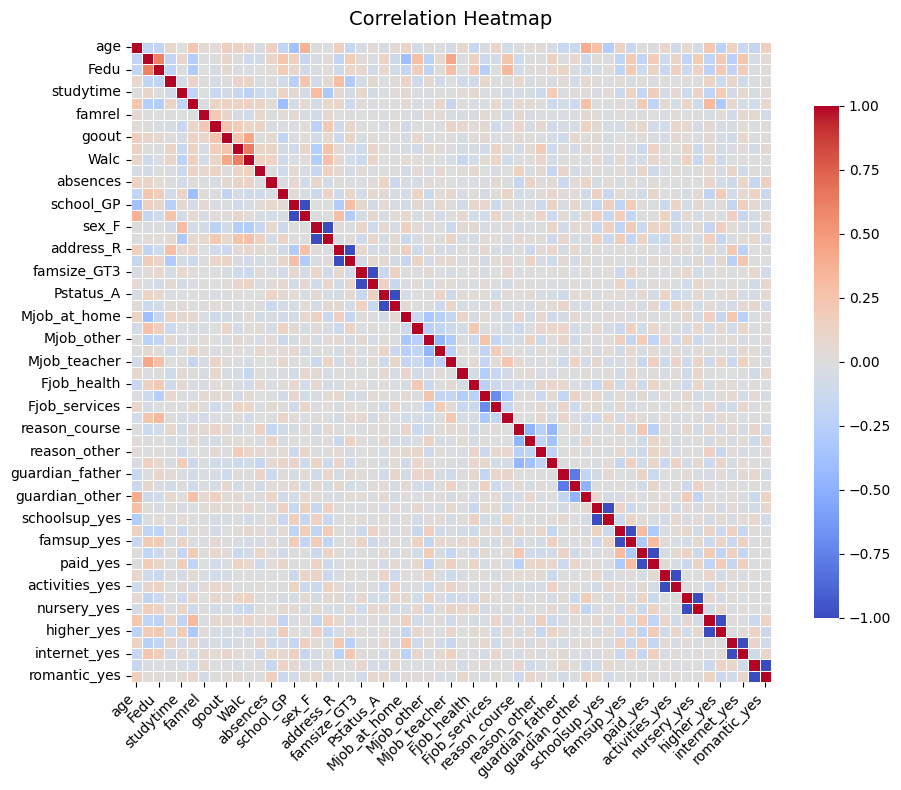

In [14]:
df_n,_,_= _data_cleaning(df_train)
heatmap_corr(df_n)

In [15]:


class Model(nn.Module):
    def __init__(self,
                 n_features:int,
                 layers:Iterable,
                 dropout:float,
                 ) -> None:
        super().__init__()

        self.depth:int = len(layers)
        self.layers:Iterable = layers
        self.n_features:int = n_features

        stack:list = []
        init:int = self.n_features
        for n in layers:
            if (n == None) or (n==0): continue
            stack.append(nn.Linear(init, n))
            stack.append(nn.Dropout(p = dropout))
            stack.append(nn.ReLU())
            # the inputs of next layer are the output of the preivous one
            init = n 
        
        # Final Layer
        stack.append(nn.Linear(init,1))
        stack.append(nn.Softplus()) #ensuring positivity

        self.net = nn.Sequential(*stack)

    def forward(self, x):
        return self.net(x)


class Trainer():

    def __init__(self,
                 model:nn.Module,
                 data:Union[pd.DataFrame],
                 batch_size:int,
                 lr:float,
                 epochs:int = 100
                 ):
        
        if torch.cuda.is_available():
            torch.set_default_device('cpu') # default cpu
            print('Running on GPU\n')

        self.model:nn.Module = model
        self.data:Union[pd.DataFrame] = data
        self.batch_size:int = batch_size
        self.lr:float = lr
        self.n_epochs:int = epochs

        self.optimizer:torch.optim = torch.optim.Adam(model.parameters(), lr=lr)
        self.loss_f = nn.MSELoss()

        self._reset()


    def _reset(self):

        fnc = lambda x: torch.tensor(x.values,dtype=torch.float32)
        x_train, x_test, y_train, y_test = map(fnc,self.data)

        train_ds = TensorDataset(x_train, y_train)
        test_ds  = TensorDataset(x_test, y_test)
        self.train_dl = DataLoader(train_ds, batch_size=self.batch_size, shuffle=True)
        self.test_dl  = DataLoader(test_ds, batch_size=self.batch_size, shuffle=False)

    def train(self):
        
        for epoch in range(self.n_epochs):
            self.model.train()
            for x, y in self.train_dl:
                # self.optimizer.zero_grad() # for performance not necessary
                pred = self.model(x)
                loss = self.loss_f(pred, y)
                loss.backward()
                self.optimizer.step()

    def evaluate(self) -> float:

        self.model.eval()
        total_loss:float = 0.0
        n:float = 0.0

        for x, y in self.test_dl: #test data
            pred = self.model(x)
            loss = self.loss_f(pred, y)
            elmnts = x.size(0)
            # by default MSELoss does the mean (1/n)(yp-y)^2, i.e. multiply by N to offset
            total_loss += loss.item() * elmnts 
            n += elmnts

        mse = (total_loss/n)
        print(f'Evaluated Model. MSE: {round(mse,3)}')

        return mse


            
def objective(trial, data_:list):
    """Objective function to be optimized by Optuna.

    Hyperparameters chosen to be optimized: optimizer, learning rate,
    dropout values, number of filters of 

    Inputs:
        - trial (optuna.trial._trial.Trial): Optuna trial
    Returns:
        - accuracy(torch.Tensor): The test accuracy. Parameter to be maximized.
    """

    x_train, x_test, y_train, y_test = data_

    dropout_prob = trial.suggest_float("dropout_prob", 0.05, 0.5)
    n_layers = trial.suggest_int("n_layers", 1, 4)
    layers_ = [trial.suggest_int(f"l{i}_nodes", 1, 128, step=1) for i in range(n_layers)] #maybe we can do something similar also for the nn.Linear
    lr_ = trial.suggest_float('learning_rate', 1e-4,1e-3,log=True)
    batch_size_ = trial.suggest_int('batch_size', 2, 32, step=1)
    n_epochs = trial.suggest_int('n_epochs', 100, 800, step = 50)

    # Generate the model
    NN_model = Model(n_features=len(x_train.columns),
                     layers=layers_,
                     dropout=dropout_prob)



    trainer = Trainer(model = NN_model,
                      data = data_,
                      batch_size = batch_size_,
                      lr = lr_,
                      epochs=n_epochs)

    return trainer.evaluate()

In [16]:
x_train, x_test, y_train, y_test = dataNN(df_train)
data_:list[pd.DataFrame] = [x_train, x_test, y_train, y_test]

NO DUPLICATES


In [17]:
x_train.shape

(252, 56)

In [18]:

objF = partial(objective, data_=data_)

study = optuna.create_study(
    study_name = 'NN_score',
    storage= 'sqlite:///optuna-study/optuna-study.db',
    direction= 'minimize',
    load_if_exists=True) 

study.optimize(objF, n_trials=500)


[I 2025-10-11 19:55:28,442] Using an existing study with name 'NN_score' instead of creating a new one.
/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([31])) that is different to the input size (torch.Size([31, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[I 2025-10-11 19:55:31,501] Trial 10044 finished with value: 2.1075101643800735 and parameters: {'dropout_prob': 0.41202497937713767, 'n_lay

Evaluated Model. MSE: 2.108


[I 2025-10-11 19:55:31,738] Trial 10045 finished with value: 1.8498019371181726 and parameters: {'dropout_prob': 0.4259697463888692, 'n_layers': 3, 'l0_nodes': 68, 'l1_nodes': 72, 'l2_nodes': 89, 'learning_rate': 0.0001014629974746135, 'batch_size': 31, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.85


[I 2025-10-11 19:55:31,974] Trial 10046 finished with value: 2.02619587816298 and parameters: {'dropout_prob': 0.3990167576821457, 'n_layers': 3, 'l0_nodes': 127, 'l1_nodes': 10, 'l2_nodes': 87, 'learning_rate': 0.00010114819343313789, 'batch_size': 31, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.026


[I 2025-10-11 19:55:32,203] Trial 10047 finished with value: 1.8766054715961218 and parameters: {'dropout_prob': 0.41589282150658746, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 11, 'l2_nodes': 10, 'learning_rate': 0.0001011180984275937, 'batch_size': 31, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.877


/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[I 2025-10-11 19:55:32,461] Trial 10048 finished with value: 1.8593223132193089 and parameters: {'dropout_prob': 0.40606627941954043, 'n_layers': 3, 'l0_nodes': 88, 'l1_nodes': 67, 'l2_nodes': 78, 'learning_rate': 0.00010161623106558393, 'batch

Evaluated Model. MSE: 1.859


[I 2025-10-11 19:55:32,706] Trial 10049 finished with value: 1.936123626306653 and parameters: {'dropout_prob': 0.448387316073215, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 70, 'l2_nodes': 70, 'learning_rate': 0.00010138307543462026, 'batch_size': 31, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.936


[I 2025-10-11 19:55:32,943] Trial 10050 finished with value: 2.006870836019516 and parameters: {'dropout_prob': 0.41258557932632894, 'n_layers': 3, 'l0_nodes': 23, 'l1_nodes': 126, 'l2_nodes': 111, 'learning_rate': 0.00010150703844975487, 'batch_size': 31, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.007


/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([18])) that is different to the input size (torch.Size([18, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[I 2025-10-11 19:55:33,201] Trial 10051 finished with value: 1.911768440157175 and parameters: {'dropout_prob': 0.4159842917268933, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 95, 'l2_nodes': 97, 'learning_rate': 0.00010224343240304051, 'batch

Evaluated Model. MSE: 1.912


/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[I 2025-10-11 19:55:33,445] Trial 10052 finished with value: 2.049363672733307 and parameters: {'dropout_prob': 0.39951985403813334, 'n_layers': 3, 'l0_nodes': 71, 'l1_nodes': 98, 'l2_nodes': 10, 'learning_rate': 0.00010097112456220795, 'batch_

Evaluated Model. MSE: 2.049


/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[I 2025-10-11 19:55:33,677] Trial 10053 finished with value: 1.8387392163276672 and parameters: {'dropout_prob': 0.4283312332715027, 'n_layers': 3, 'l0_nodes': 110, 'l1_nodes': 18, 'l2_nodes': 101, 'learning_rate': 0.00010143227896090438, 'batch_size': 32, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.839


[I 2025-10-11 19:55:33,919] Trial 10054 finished with value: 1.8745169453322887 and parameters: {'dropout_prob': 0.3986598988219967, 'n_layers': 3, 'l0_nodes': 100, 'l1_nodes': 68, 'l2_nodes': 67, 'learning_rate': 0.00010090907626239124, 'batch_size': 30, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.875


/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[I 2025-10-11 19:55:34,154] Trial 10055 finished with value: 1.764627369120717 and parameters: {'dropout_prob': 0.4322518632912403, 'n_layers': 3, 'l0_nodes': 75, 'l1_nodes': 82, 'l2_nodes': 12, 'learning_rate': 0.00010150479520659986, 'batch_size': 15, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.765


/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[I 2025-10-11 19:55:34,407] Trial 10056 finished with value: 1.9045022670179605 and parameters: {'dropout_prob': 0.41905361524858015, 'n_layers': 3, 'l0_nodes': 79, 'l1_nodes': 120, 'l2_nodes': 102, 'learning_rate': 0.00010122431682509015, 'b

Evaluated Model. MSE: 1.905


[I 2025-10-11 19:55:34,646] Trial 10057 finished with value: 1.9987803008407354 and parameters: {'dropout_prob': 0.4182405980895515, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 67, 'l2_nodes': 74, 'learning_rate': 0.00010137937530901198, 'batch_size': 31, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.999


/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[I 2025-10-11 19:55:34,876] Trial 10058 finished with value: 2.1926328539848328 and parameters: {'dropout_prob': 0.4052653490112144, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 69, 'l2_nodes': 9, 'learning_rate': 0.00010140652215871919, 'batch_size': 16, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.193


[I 2025-10-11 19:55:35,114] Trial 10059 finished with value: 2.0058461651206017 and parameters: {'dropout_prob': 0.41093458314607423, 'n_layers': 3, 'l0_nodes': 75, 'l1_nodes': 99, 'l2_nodes': 12, 'learning_rate': 0.00010399020774545261, 'batch_size': 30, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.006


[I 2025-10-11 19:55:35,348] Trial 10060 finished with value: 1.7995875384658575 and parameters: {'dropout_prob': 0.33073956260841614, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 88, 'l2_nodes': 78, 'learning_rate': 0.00010132744736528524, 'batch_size': 31, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.8


/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[I 2025-10-11 19:55:35,585] Trial 10061 finished with value: 1.9411537125706673 and parameters: {'dropout_prob': 0.323247967664436, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 15, 'l2_nodes': 9, 'learning_rate': 0.00010426218756945527, 'batch_si

Evaluated Model. MSE: 1.941


[I 2025-10-11 19:55:35,829] Trial 10062 finished with value: 1.8618335500359535 and parameters: {'dropout_prob': 0.44845593318870075, 'n_layers': 3, 'l0_nodes': 125, 'l1_nodes': 67, 'l2_nodes': 91, 'learning_rate': 0.00010221500803122795, 'batch_size': 30, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.862


[I 2025-10-11 19:55:36,070] Trial 10063 finished with value: 2.233986873179674 and parameters: {'dropout_prob': 0.41244033692577187, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 74, 'l2_nodes': 9, 'learning_rate': 0.0001008170825199885, 'batch_size': 31, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.234


[I 2025-10-11 19:55:36,300] Trial 10064 finished with value: 1.9038185272365808 and parameters: {'dropout_prob': 0.4601891233299301, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 14, 'l2_nodes': 80, 'learning_rate': 0.00010109893160145269, 'batch_size': 15, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.904


[I 2025-10-11 19:55:36,540] Trial 10065 finished with value: 1.7804171741008759 and parameters: {'dropout_prob': 0.40922015983076665, 'n_layers': 3, 'l0_nodes': 81, 'l1_nodes': 32, 'l2_nodes': 9, 'learning_rate': 0.00010127201844431914, 'batch_size': 31, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.78


[I 2025-10-11 19:55:36,786] Trial 10066 finished with value: 2.048424333333969 and parameters: {'dropout_prob': 0.4169705724666896, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 88, 'l2_nodes': 126, 'learning_rate': 0.00010073897170764807, 'batch_size': 15, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.048


[I 2025-10-11 19:55:37,027] Trial 10067 finished with value: 1.7974294852465391 and parameters: {'dropout_prob': 0.4118637329794566, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 15, 'l2_nodes': 10, 'learning_rate': 0.00010120559302305048, 'batch_size': 31, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.797


[I 2025-10-11 19:55:37,264] Trial 10068 finished with value: 1.7439593467861414 and parameters: {'dropout_prob': 0.4045203761799003, 'n_layers': 3, 'l0_nodes': 70, 'l1_nodes': 67, 'l2_nodes': 10, 'learning_rate': 0.00010059586385205546, 'batch_size': 29, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.744


/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([14, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[I 2025-10-11 19:55:37,501] Trial 10069 finished with value: 1.923895988613367 and parameters: {'dropout_prob': 0.4028083009028513, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 84, 'l2_nodes': 9, 'learning_rate': 0.00010056781235450973, 'batch_size': 14, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.924


/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[I 2025-10-11 19:55:37,733] Trial 10070 finished with value: 2.0103041529655457 and parameters: {'dropout_prob': 0.42395472671296147, 'n_layers': 3, 'l0_nodes': 125, 'l1_nodes': 65, 'l2_nodes': 9, 'learning_rate': 0.00010047346790472355, 'batch_size': 26, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.01


[I 2025-10-11 19:55:37,964] Trial 10071 finished with value: 2.008393406867981 and parameters: {'dropout_prob': 0.39857194924786477, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 68, 'l2_nodes': 9, 'learning_rate': 0.00010088593905512422, 'batch_size': 16, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.008


[I 2025-10-11 19:55:38,212] Trial 10072 finished with value: 2.0282592102885246 and parameters: {'dropout_prob': 0.3998641635170138, 'n_layers': 3, 'l0_nodes': 123, 'l1_nodes': 71, 'l2_nodes': 9, 'learning_rate': 0.00010106023699353818, 'batch_size': 13, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.028


/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([17, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[I 2025-10-11 19:55:38,458] Trial 10073 finished with value: 2.055799899622798 and parameters: {'dropout_prob': 0.4137534737394341, 'n_layers': 3, 'l0_nodes': 111, 'l1_nodes': 32, 'l2_nodes': 68, 'learning_rate': 0.000100355394070946, 'batch_size': 17, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.056


[I 2025-10-11 19:55:38,686] Trial 10074 finished with value: 1.690483033657074 and parameters: {'dropout_prob': 0.48935023949449286, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 82, 'l2_nodes': 8, 'learning_rate': 0.00010133064700238698, 'batch_size': 16, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.69


[I 2025-10-11 19:55:38,928] Trial 10075 finished with value: 1.914564672857523 and parameters: {'dropout_prob': 0.4006922434006421, 'n_layers': 3, 'l0_nodes': 84, 'l1_nodes': 16, 'l2_nodes': 10, 'learning_rate': 0.00010218264585868265, 'batch_size': 31, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.915


[I 2025-10-11 19:55:39,150] Trial 10076 finished with value: 1.7731806486845016 and parameters: {'dropout_prob': 0.40408465025428064, 'n_layers': 3, 'l0_nodes': 67, 'l1_nodes': 14, 'l2_nodes': 111, 'learning_rate': 0.0001010509176454226, 'batch_size': 28, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.773


[I 2025-10-11 19:55:39,383] Trial 10077 finished with value: 1.7734465561807156 and parameters: {'dropout_prob': 0.4059302276842629, 'n_layers': 3, 'l0_nodes': 74, 'l1_nodes': 121, 'l2_nodes': 10, 'learning_rate': 0.0001010207210795952, 'batch_size': 30, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.773


[I 2025-10-11 19:55:39,629] Trial 10078 finished with value: 1.9035831689834595 and parameters: {'dropout_prob': 0.4383894617092771, 'n_layers': 3, 'l0_nodes': 85, 'l1_nodes': 79, 'l2_nodes': 9, 'learning_rate': 0.00010090648532051293, 'batch_size': 28, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.904


[I 2025-10-11 19:55:39,858] Trial 10079 finished with value: 2.0363972429186106 and parameters: {'dropout_prob': 0.40921109265361644, 'n_layers': 3, 'l0_nodes': 123, 'l1_nodes': 127, 'l2_nodes': 9, 'learning_rate': 0.00010096640546745952, 'batch_size': 31, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.036


[I 2025-10-11 19:55:40,090] Trial 10080 finished with value: 1.9219745453447104 and parameters: {'dropout_prob': 0.47656322004438056, 'n_layers': 3, 'l0_nodes': 23, 'l1_nodes': 84, 'l2_nodes': 10, 'learning_rate': 0.0001010443360598445, 'batch_size': 29, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.922


[I 2025-10-11 19:55:40,327] Trial 10081 finished with value: 1.7852272540330887 and parameters: {'dropout_prob': 0.4099805305547619, 'n_layers': 3, 'l0_nodes': 108, 'l1_nodes': 73, 'l2_nodes': 11, 'learning_rate': 0.00010063946604456612, 'batch_size': 14, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.785


[I 2025-10-11 19:55:40,565] Trial 10082 finished with value: 1.936622615903616 and parameters: {'dropout_prob': 0.406337361076231, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 17, 'l2_nodes': 122, 'learning_rate': 0.00010130379987452735, 'batch_size': 31, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.937


[I 2025-10-11 19:55:40,808] Trial 10083 finished with value: 2.072363020852208 and parameters: {'dropout_prob': 0.42100715555474544, 'n_layers': 3, 'l0_nodes': 101, 'l1_nodes': 17, 'l2_nodes': 10, 'learning_rate': 0.00010093746683631212, 'batch_size': 29, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.072


[I 2025-10-11 19:55:41,055] Trial 10084 finished with value: 1.9201711975038052 and parameters: {'dropout_prob': 0.4032819378815341, 'n_layers': 3, 'l0_nodes': 110, 'l1_nodes': 16, 'l2_nodes': 103, 'learning_rate': 0.000101010924282199, 'batch_size': 18, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.92


[I 2025-10-11 19:55:41,283] Trial 10085 finished with value: 1.8882248867303133 and parameters: {'dropout_prob': 0.4113222169081252, 'n_layers': 3, 'l0_nodes': 96, 'l1_nodes': 100, 'l2_nodes': 11, 'learning_rate': 0.00010239236279226623, 'batch_size': 31, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.888


[I 2025-10-11 19:55:41,514] Trial 10086 finished with value: 1.9988075029104948 and parameters: {'dropout_prob': 0.40199815904243424, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 112, 'l2_nodes': 85, 'learning_rate': 0.0001008528335291465, 'batch_size': 17, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.999


[I 2025-10-11 19:55:41,740] Trial 10087 finished with value: 1.8013263493776321 and parameters: {'dropout_prob': 0.4110548569944633, 'n_layers': 3, 'l0_nodes': 70, 'l1_nodes': 15, 'l2_nodes': 83, 'learning_rate': 0.000105926815850364, 'batch_size': 30, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.801


[I 2025-10-11 19:55:41,970] Trial 10088 finished with value: 1.7832208658801392 and parameters: {'dropout_prob': 0.4059385028991261, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 13, 'l2_nodes': 6, 'learning_rate': 0.00010104424222527975, 'batch_size': 2, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.783


[I 2025-10-11 19:55:42,209] Trial 10089 finished with value: 2.170170597732067 and parameters: {'dropout_prob': 0.4095712218285461, 'n_layers': 3, 'l0_nodes': 109, 'l1_nodes': 66, 'l2_nodes': 12, 'learning_rate': 0.00010120235901992391, 'batch_size': 30, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.17


[I 2025-10-11 19:55:42,451] Trial 10090 finished with value: 1.6607456132769585 and parameters: {'dropout_prob': 0.4525927111543846, 'n_layers': 3, 'l0_nodes': 72, 'l1_nodes': 67, 'l2_nodes': 9, 'learning_rate': 0.00010073280958065631, 'batch_size': 26, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.661


[I 2025-10-11 19:55:42,687] Trial 10091 finished with value: 2.006505511701107 and parameters: {'dropout_prob': 0.39958060610282226, 'n_layers': 3, 'l0_nodes': 98, 'l1_nodes': 14, 'l2_nodes': 114, 'learning_rate': 0.00010065591842869425, 'batch_size': 15, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.007


[I 2025-10-11 19:55:42,916] Trial 10092 finished with value: 1.8709157574921846 and parameters: {'dropout_prob': 0.40990379581029335, 'n_layers': 3, 'l0_nodes': 89, 'l1_nodes': 119, 'l2_nodes': 9, 'learning_rate': 0.0001005293776755648, 'batch_size': 31, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.871


[I 2025-10-11 19:55:43,179] Trial 10093 finished with value: 1.89688178896904 and parameters: {'dropout_prob': 0.3976160913291202, 'n_layers': 3, 'l0_nodes': 119, 'l1_nodes': 110, 'l2_nodes': 9, 'learning_rate': 0.00010069899563299885, 'batch_size': 13, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.897


[I 2025-10-11 19:55:43,426] Trial 10094 finished with value: 1.959265261888504 and parameters: {'dropout_prob': 0.41437906932967267, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 74, 'l2_nodes': 9, 'learning_rate': 0.00010093764197708176, 'batch_size': 16, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.959


[I 2025-10-11 19:55:43,661] Trial 10095 finished with value: 1.9080791249871254 and parameters: {'dropout_prob': 0.39956076859095674, 'n_layers': 3, 'l0_nodes': 82, 'l1_nodes': 68, 'l2_nodes': 10, 'learning_rate': 0.0001087097637202604, 'batch_size': 15, 'n_epochs': 250}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.908


[I 2025-10-11 19:55:43,894] Trial 10096 finished with value: 1.7108532302081585 and parameters: {'dropout_prob': 0.4098221184806312, 'n_layers': 3, 'l0_nodes': 81, 'l1_nodes': 67, 'l2_nodes': 9, 'learning_rate': 0.00010089375380132202, 'batch_size': 30, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.711


[I 2025-10-11 19:55:44,140] Trial 10097 finished with value: 2.270521156489849 and parameters: {'dropout_prob': 0.331960209707779, 'n_layers': 3, 'l0_nodes': 104, 'l1_nodes': 13, 'l2_nodes': 9, 'learning_rate': 0.0001004912790929188, 'batch_size': 31, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.271


[I 2025-10-11 19:55:44,386] Trial 10098 finished with value: 2.0389921069145203 and parameters: {'dropout_prob': 0.40921296174167354, 'n_layers': 3, 'l0_nodes': 107, 'l1_nodes': 14, 'l2_nodes': 9, 'learning_rate': 0.00010066059446857325, 'batch_size': 16, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.039


[I 2025-10-11 19:55:44,636] Trial 10099 finished with value: 1.6846094727516174 and parameters: {'dropout_prob': 0.40056754645405085, 'n_layers': 3, 'l0_nodes': 80, 'l1_nodes': 15, 'l2_nodes': 11, 'learning_rate': 0.00010142817925039447, 'batch_size': 32, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.685


[I 2025-10-11 19:55:44,895] Trial 10100 finished with value: 1.8326578624546528 and parameters: {'dropout_prob': 0.42329014869823894, 'n_layers': 3, 'l0_nodes': 69, 'l1_nodes': 121, 'l2_nodes': 9, 'learning_rate': 0.00010068943150579088, 'batch_size': 14, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.833


[I 2025-10-11 19:55:45,126] Trial 10101 finished with value: 1.817873302847147 and parameters: {'dropout_prob': 0.42540075122607446, 'n_layers': 3, 'l0_nodes': 78, 'l1_nodes': 108, 'l2_nodes': 70, 'learning_rate': 0.00010063995924268189, 'batch_size': 31, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.818


[I 2025-10-11 19:55:45,357] Trial 10102 finished with value: 1.8406654689460993 and parameters: {'dropout_prob': 0.3972883774797624, 'n_layers': 3, 'l0_nodes': 79, 'l1_nodes': 12, 'l2_nodes': 11, 'learning_rate': 0.00010855495189732372, 'batch_size': 17, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.841


[I 2025-10-11 19:55:45,590] Trial 10103 finished with value: 1.96900287643075 and parameters: {'dropout_prob': 0.3278667492484644, 'n_layers': 3, 'l0_nodes': 124, 'l1_nodes': 75, 'l2_nodes': 9, 'learning_rate': 0.00010055220832000317, 'batch_size': 31, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.969


[I 2025-10-11 19:55:45,837] Trial 10104 finished with value: 1.7588543938472867 and parameters: {'dropout_prob': 0.40504630859301816, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 14, 'l2_nodes': 9, 'learning_rate': 0.00010077977666776125, 'batch_size': 15, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.759


[I 2025-10-11 19:55:46,075] Trial 10105 finished with value: 1.974733181297779 and parameters: {'dropout_prob': 0.4177384589966771, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 122, 'l2_nodes': 92, 'learning_rate': 0.00010088592071273647, 'batch_size': 30, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.975


[I 2025-10-11 19:55:46,299] Trial 10106 finished with value: 1.9124094936996698 and parameters: {'dropout_prob': 0.43849242578713055, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 66, 'l2_nodes': 9, 'learning_rate': 0.00010088820726834904, 'batch_size': 31, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.912


[I 2025-10-11 19:55:46,536] Trial 10107 finished with value: 1.7875828482210636 and parameters: {'dropout_prob': 0.491660125626705, 'n_layers': 3, 'l0_nodes': 86, 'l1_nodes': 96, 'l2_nodes': 9, 'learning_rate': 0.00010117949116262904, 'batch_size': 30, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.788


[I 2025-10-11 19:55:46,773] Trial 10108 finished with value: 1.7439145799726248 and parameters: {'dropout_prob': 0.47687939796945766, 'n_layers': 3, 'l0_nodes': 75, 'l1_nodes': 67, 'l2_nodes': 8, 'learning_rate': 0.00010092048365795886, 'batch_size': 13, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.744


[I 2025-10-11 19:55:47,033] Trial 10109 finished with value: 1.7609945014119148 and parameters: {'dropout_prob': 0.4077490726712407, 'n_layers': 3, 'l0_nodes': 90, 'l1_nodes': 33, 'l2_nodes': 11, 'learning_rate': 0.00010047158454725964, 'batch_size': 14, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.761


[I 2025-10-11 19:55:47,265] Trial 10110 finished with value: 1.789845721796155 and parameters: {'dropout_prob': 0.4034370928194623, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 14, 'l2_nodes': 9, 'learning_rate': 0.00010086385389410641, 'batch_size': 17, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.79


[I 2025-10-11 19:55:47,500] Trial 10111 finished with value: 1.9418473541736603 and parameters: {'dropout_prob': 0.40346271969212455, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 14, 'l2_nodes': 9, 'learning_rate': 0.00010055584748708617, 'batch_size': 29, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.942


[I 2025-10-11 19:55:47,750] Trial 10112 finished with value: 2.1538896411657333 and parameters: {'dropout_prob': 0.4045854017978459, 'n_layers': 3, 'l0_nodes': 98, 'l1_nodes': 32, 'l2_nodes': 9, 'learning_rate': 0.0001007777295599178, 'batch_size': 30, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.154


[I 2025-10-11 19:55:47,985] Trial 10113 finished with value: 2.041827291250229 and parameters: {'dropout_prob': 0.4771440844849826, 'n_layers': 3, 'l0_nodes': 77, 'l1_nodes': 35, 'l2_nodes': 8, 'learning_rate': 0.00010146563345655542, 'batch_size': 16, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.042


[I 2025-10-11 19:55:48,216] Trial 10114 finished with value: 1.9040376152843237 and parameters: {'dropout_prob': 0.42167560011069516, 'n_layers': 3, 'l0_nodes': 123, 'l1_nodes': 66, 'l2_nodes': 122, 'learning_rate': 0.00010090752889762063, 'batch_size': 31, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.904


[I 2025-10-11 19:55:48,455] Trial 10115 finished with value: 1.977601371705532 and parameters: {'dropout_prob': 0.40101003125811935, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 69, 'l2_nodes': 74, 'learning_rate': 0.00010079615803869238, 'batch_size': 29, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.978


[I 2025-10-11 19:55:48,690] Trial 10116 finished with value: 2.105902398005128 and parameters: {'dropout_prob': 0.4159645716572922, 'n_layers': 3, 'l0_nodes': 81, 'l1_nodes': 32, 'l2_nodes': 9, 'learning_rate': 0.00010069111428467251, 'batch_size': 13, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.106


[I 2025-10-11 19:55:48,934] Trial 10117 finished with value: 2.2379452288150787 and parameters: {'dropout_prob': 0.42908044643651355, 'n_layers': 3, 'l0_nodes': 69, 'l1_nodes': 14, 'l2_nodes': 9, 'learning_rate': 0.0001012367262237026, 'batch_size': 16, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.238


[I 2025-10-11 19:55:49,158] Trial 10118 finished with value: 1.9903638698160648 and parameters: {'dropout_prob': 0.39587774175696894, 'n_layers': 3, 'l0_nodes': 23, 'l1_nodes': 11, 'l2_nodes': 98, 'learning_rate': 0.00010088250427384252, 'batch_size': 15, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.99


/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[I 2025-10-11 19:55:49,398] Trial 10119 finished with value: 2.0059690177440643 and parameters: {'dropout_prob': 0.4192931068045131, 'n_layers': 3, 'l0_nodes': 23, 'l1_nodes': 13, 'l2_nodes': 9, 'learning_rate': 0.00010137705144556184, 'batch_size': 24, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.006


[I 2025-10-11 19:55:49,648] Trial 10120 finished with value: 1.9847398847341537 and parameters: {'dropout_prob': 0.40334481274400236, 'n_layers': 3, 'l0_nodes': 117, 'l1_nodes': 14, 'l2_nodes': 8, 'learning_rate': 0.00010051086790949208, 'batch_size': 31, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.985


[I 2025-10-11 19:55:49,886] Trial 10121 finished with value: 1.8456524182111025 and parameters: {'dropout_prob': 0.4070484299677922, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 11, 'l2_nodes': 10, 'learning_rate': 0.00010094283947067822, 'batch_size': 29, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.846


[I 2025-10-11 19:55:50,135] Trial 10122 finished with value: 1.6301181633025408 and parameters: {'dropout_prob': 0.41343837747119194, 'n_layers': 3, 'l0_nodes': 23, 'l1_nodes': 15, 'l2_nodes': 8, 'learning_rate': 0.00010120988012301438, 'batch_size': 31, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.63


[I 2025-10-11 19:55:50,369] Trial 10123 finished with value: 1.913752630352974 and parameters: {'dropout_prob': 0.4176427034955009, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 13, 'l2_nodes': 9, 'learning_rate': 0.00010071997262772106, 'batch_size': 28, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.914


[I 2025-10-11 19:55:50,604] Trial 10124 finished with value: 2.21998362056911 and parameters: {'dropout_prob': 0.4100300067760707, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 13, 'l2_nodes': 10, 'learning_rate': 0.00010026064890385783, 'batch_size': 13, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.22


/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([19])) that is different to the input size (torch.Size([19, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[I 2025-10-11 19:55:50,840] Trial 10125 finished with value: 1.9640265833586454 and parameters: {'dropout_prob': 0.4148386878815875, 'n_layers': 3, 'l0_nodes': 97, 'l1_nodes': 66, 'l2_nodes': 11, 'learning_rate': 0.00010047566514600333, 'batch_

Evaluated Model. MSE: 1.964


[I 2025-10-11 19:55:51,077] Trial 10126 finished with value: 1.9983084201812744 and parameters: {'dropout_prob': 0.41423771561029615, 'n_layers': 3, 'l0_nodes': 86, 'l1_nodes': 15, 'l2_nodes': 10, 'learning_rate': 0.0001006817012623839, 'batch_size': 16, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.998


[I 2025-10-11 19:55:51,316] Trial 10127 finished with value: 2.1086764596402645 and parameters: {'dropout_prob': 0.40029592239688894, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 112, 'l2_nodes': 9, 'learning_rate': 0.0001006250826048853, 'batch_size': 26, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.109


[I 2025-10-11 19:55:51,565] Trial 10128 finished with value: 2.072755601257086 and parameters: {'dropout_prob': 0.40420528758258434, 'n_layers': 3, 'l0_nodes': 114, 'l1_nodes': 104, 'l2_nodes': 9, 'learning_rate': 0.00010060459119666945, 'batch_size': 29, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.073


[I 2025-10-11 19:55:51,801] Trial 10129 finished with value: 1.8671187609434128 and parameters: {'dropout_prob': 0.33942448774235157, 'n_layers': 3, 'l0_nodes': 128, 'l1_nodes': 13, 'l2_nodes': 9, 'learning_rate': 0.00010109533267583808, 'batch_size': 14, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.867


[I 2025-10-11 19:55:52,038] Trial 10130 finished with value: 1.8630203306674957 and parameters: {'dropout_prob': 0.39964878227310147, 'n_layers': 3, 'l0_nodes': 108, 'l1_nodes': 33, 'l2_nodes': 75, 'learning_rate': 0.00010068478977286469, 'batch_size': 14, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.863


/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([9])) that is different to the input size (torch.Size([9, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[I 2025-10-11 19:55:52,282] Trial 10131 finished with value: 1.7570063788443804 and parameters: {'dropout_prob': 0.42012797928111384, 'n_layers': 3, 'l0_nodes': 67, 'l1_nodes': 8, 'l2_nodes': 96, 'learning_rate': 0.00010055032764057491, 'batch_

Evaluated Model. MSE: 1.757


[I 2025-10-11 19:55:52,519] Trial 10132 finished with value: 1.9688420314341784 and parameters: {'dropout_prob': 0.3991482217733632, 'n_layers': 3, 'l0_nodes': 104, 'l1_nodes': 91, 'l2_nodes': 82, 'learning_rate': 0.00010060271884625331, 'batch_size': 15, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.969


[I 2025-10-11 19:55:52,757] Trial 10133 finished with value: 1.9024714902043343 and parameters: {'dropout_prob': 0.3285164663206923, 'n_layers': 3, 'l0_nodes': 111, 'l1_nodes': 31, 'l2_nodes': 105, 'learning_rate': 0.00010102652217512191, 'batch_size': 28, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.902


[I 2025-10-11 19:55:52,997] Trial 10134 finished with value: 1.6637670807540417 and parameters: {'dropout_prob': 0.4069886504876214, 'n_layers': 3, 'l0_nodes': 98, 'l1_nodes': 33, 'l2_nodes': 9, 'learning_rate': 0.00010035227294076833, 'batch_size': 31, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.664


[I 2025-10-11 19:55:53,232] Trial 10135 finished with value: 1.84674421697855 and parameters: {'dropout_prob': 0.33282810423655845, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 76, 'l2_nodes': 72, 'learning_rate': 0.00010070413235992616, 'batch_size': 30, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.847


[I 2025-10-11 19:55:53,503] Trial 10136 finished with value: 2.2113222405314445 and parameters: {'dropout_prob': 0.4120682127215269, 'n_layers': 3, 'l0_nodes': 68, 'l1_nodes': 71, 'l2_nodes': 8, 'learning_rate': 0.0001004474206753029, 'batch_size': 15, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.211


[I 2025-10-11 19:55:53,738] Trial 10137 finished with value: 2.048856360837817 and parameters: {'dropout_prob': 0.40713053518067877, 'n_layers': 3, 'l0_nodes': 100, 'l1_nodes': 16, 'l2_nodes': 9, 'learning_rate': 0.00010083787936688024, 'batch_size': 31, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.049


[I 2025-10-11 19:55:53,973] Trial 10138 finished with value: 1.7183212079107761 and parameters: {'dropout_prob': 0.34229225639511557, 'n_layers': 3, 'l0_nodes': 90, 'l1_nodes': 114, 'l2_nodes': 9, 'learning_rate': 0.00010040717018033661, 'batch_size': 31, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.718


[I 2025-10-11 19:55:54,212] Trial 10139 finished with value: 1.9588742665946484 and parameters: {'dropout_prob': 0.4102831127139938, 'n_layers': 3, 'l0_nodes': 73, 'l1_nodes': 114, 'l2_nodes': 9, 'learning_rate': 0.00010098210449102222, 'batch_size': 14, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.959


[I 2025-10-11 19:55:54,482] Trial 10140 finished with value: 1.746220886707306 and parameters: {'dropout_prob': 0.3977655566910897, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 11, 'l2_nodes': 9, 'learning_rate': 0.00010064448732810758, 'batch_size': 16, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.746


[I 2025-10-11 19:55:54,729] Trial 10141 finished with value: 1.7476284559816122 and parameters: {'dropout_prob': 0.4856358044929566, 'n_layers': 3, 'l0_nodes': 121, 'l1_nodes': 69, 'l2_nodes': 9, 'learning_rate': 0.00010058778938929864, 'batch_size': 31, 'n_epochs': 600}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.748


[I 2025-10-11 19:55:54,970] Trial 10142 finished with value: 2.0669332072138786 and parameters: {'dropout_prob': 0.41418850005184216, 'n_layers': 3, 'l0_nodes': 66, 'l1_nodes': 70, 'l2_nodes': 9, 'learning_rate': 0.00010109841454739934, 'batch_size': 30, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.067


[I 2025-10-11 19:55:55,209] Trial 10143 finished with value: 2.060491219162941 and parameters: {'dropout_prob': 0.4666721948509582, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 108, 'l2_nodes': 9, 'learning_rate': 0.00010079895339243628, 'batch_size': 31, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.06


[I 2025-10-11 19:55:55,452] Trial 10144 finished with value: 1.919218860566616 and parameters: {'dropout_prob': 0.40782672186728025, 'n_layers': 3, 'l0_nodes': 73, 'l1_nodes': 11, 'l2_nodes': 95, 'learning_rate': 0.00010066768274453193, 'batch_size': 28, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.919


/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([27])) that is different to the input size (torch.Size([27, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[I 2025-10-11 19:55:55,695] Trial 10145 finished with value: 2.161268724128604 and parameters: {'dropout_prob': 0.40822173805393985, 'n_layers': 3, 'l0_nodes': 75, 'l1_nodes': 94, 'l2_nodes': 9, 'learning_rate': 0.0003328206534029539, 'batch_size': 27, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.161


/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[I 2025-10-11 19:55:55,930] Trial 10146 finished with value: 2.2951284497976303 and parameters: {'dropout_prob': 0.4096520576905192, 'n_layers': 3, 'l0_nodes': 86, 'l1_nodes': 15, 'l2_nodes': 9, 'learning_rate': 0.00010095516268167875, 'batch_s

Evaluated Model. MSE: 2.295


[I 2025-10-11 19:55:56,167] Trial 10147 finished with value: 1.8539082603529096 and parameters: {'dropout_prob': 0.4043318663134447, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 32, 'l2_nodes': 9, 'learning_rate': 0.00010082111891143642, 'batch_size': 15, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.854


[I 2025-10-11 19:55:56,405] Trial 10148 finished with value: 2.0170273445546627 and parameters: {'dropout_prob': 0.45700597574943347, 'n_layers': 3, 'l0_nodes': 119, 'l1_nodes': 30, 'l2_nodes': 9, 'learning_rate': 0.00010149500287075045, 'batch_size': 26, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.017


[I 2025-10-11 19:55:56,661] Trial 10149 finished with value: 1.7812674790620804 and parameters: {'dropout_prob': 0.4059772443074646, 'n_layers': 3, 'l0_nodes': 89, 'l1_nodes': 118, 'l2_nodes': 8, 'learning_rate': 0.00010089748342549341, 'batch_size': 30, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.781


[I 2025-10-11 19:55:56,899] Trial 10150 finished with value: 1.8934423197060823 and parameters: {'dropout_prob': 0.40946558081181755, 'n_layers': 3, 'l0_nodes': 71, 'l1_nodes': 33, 'l2_nodes': 8, 'learning_rate': 0.00010065654707295525, 'batch_size': 15, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.893


[I 2025-10-11 19:55:57,144] Trial 10151 finished with value: 2.022981759160757 and parameters: {'dropout_prob': 0.40909650477328197, 'n_layers': 3, 'l0_nodes': 94, 'l1_nodes': 14, 'l2_nodes': 9, 'learning_rate': 0.0001004670288148763, 'batch_size': 31, 'n_epochs': 600}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.023


[I 2025-10-11 19:55:57,381] Trial 10152 finished with value: 1.893253980204463 and parameters: {'dropout_prob': 0.40366312574239444, 'n_layers': 3, 'l0_nodes': 93, 'l1_nodes': 14, 'l2_nodes': 9, 'learning_rate': 0.00010092511547285426, 'batch_size': 31, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.893


[I 2025-10-11 19:55:57,613] Trial 10153 finished with value: 1.6748853400349617 and parameters: {'dropout_prob': 0.41622089932509443, 'n_layers': 3, 'l0_nodes': 90, 'l1_nodes': 15, 'l2_nodes': 9, 'learning_rate': 0.00010053260229514235, 'batch_size': 12, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.675


[I 2025-10-11 19:55:57,870] Trial 10154 finished with value: 1.6785877831280231 and parameters: {'dropout_prob': 0.32809981272588445, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 15, 'l2_nodes': 8, 'learning_rate': 0.00010054143907387119, 'batch_size': 14, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.679


[I 2025-10-11 19:55:58,106] Trial 10155 finished with value: 1.689881945028901 and parameters: {'dropout_prob': 0.41111250598073995, 'n_layers': 3, 'l0_nodes': 96, 'l1_nodes': 14, 'l2_nodes': 9, 'learning_rate': 0.00010097012070889713, 'batch_size': 29, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.69


[I 2025-10-11 19:55:58,343] Trial 10156 finished with value: 2.0094786286354065 and parameters: {'dropout_prob': 0.4314820053577165, 'n_layers': 3, 'l0_nodes': 128, 'l1_nodes': 65, 'l2_nodes': 9, 'learning_rate': 0.0001005822029548481, 'batch_size': 13, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.009


[I 2025-10-11 19:55:58,579] Trial 10157 finished with value: 1.9372229706496 and parameters: {'dropout_prob': 0.433604292116621, 'n_layers': 3, 'l0_nodes': 113, 'l1_nodes': 32, 'l2_nodes': 119, 'learning_rate': 0.00010086022028755226, 'batch_size': 17, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.937


[I 2025-10-11 19:55:58,836] Trial 10158 finished with value: 2.1157528050243855 and parameters: {'dropout_prob': 0.4099508173122922, 'n_layers': 3, 'l0_nodes': 68, 'l1_nodes': 15, 'l2_nodes': 9, 'learning_rate': 0.00010069341361991006, 'batch_size': 31, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.116


[I 2025-10-11 19:55:59,081] Trial 10159 finished with value: 1.9670988954603672 and parameters: {'dropout_prob': 0.4845506629574163, 'n_layers': 3, 'l0_nodes': 99, 'l1_nodes': 31, 'l2_nodes': 8, 'learning_rate': 0.00010136630449472734, 'batch_size': 30, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.967


[I 2025-10-11 19:55:59,327] Trial 10160 finished with value: 1.7083353139460087 and parameters: {'dropout_prob': 0.4139992630152774, 'n_layers': 3, 'l0_nodes': 115, 'l1_nodes': 14, 'l2_nodes': 9, 'learning_rate': 0.00010132734709150699, 'batch_size': 30, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.708


[I 2025-10-11 19:55:59,559] Trial 10161 finished with value: 2.0759099684655666 and parameters: {'dropout_prob': 0.405855266683387, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 66, 'l2_nodes': 9, 'learning_rate': 0.00010144979168893736, 'batch_size': 17, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.076


[I 2025-10-11 19:55:59,798] Trial 10162 finished with value: 1.9723480865359306 and parameters: {'dropout_prob': 0.41335335309634985, 'n_layers': 3, 'l0_nodes': 76, 'l1_nodes': 10, 'l2_nodes': 11, 'learning_rate': 0.0001007297432710768, 'batch_size': 12, 'n_epochs': 600}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.972


[I 2025-10-11 19:56:00,039] Trial 10163 finished with value: 1.7014684975147247 and parameters: {'dropout_prob': 0.4220521804247419, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 14, 'l2_nodes': 9, 'learning_rate': 0.00010061107517851314, 'batch_size': 16, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.701


[I 2025-10-11 19:56:00,299] Trial 10164 finished with value: 1.956154752522707 and parameters: {'dropout_prob': 0.3318005481335545, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 126, 'l2_nodes': 118, 'learning_rate': 0.00010077452328181785, 'batch_size': 27, 'n_epochs': 600}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.956


[I 2025-10-11 19:56:00,545] Trial 10165 finished with value: 2.052523525431752 and parameters: {'dropout_prob': 0.4112583824802726, 'n_layers': 3, 'l0_nodes': 101, 'l1_nodes': 82, 'l2_nodes': 9, 'learning_rate': 0.00010077965284249067, 'batch_size': 31, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.053


[I 2025-10-11 19:56:00,798] Trial 10166 finished with value: 1.9000122174620628 and parameters: {'dropout_prob': 0.4175859579346304, 'n_layers': 3, 'l0_nodes': 23, 'l1_nodes': 66, 'l2_nodes': 93, 'learning_rate': 0.00010942534196269947, 'batch_size': 28, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.9


[I 2025-10-11 19:56:01,053] Trial 10167 finished with value: 1.9775818064808846 and parameters: {'dropout_prob': 0.4072234952955022, 'n_layers': 3, 'l0_nodes': 112, 'l1_nodes': 33, 'l2_nodes': 9, 'learning_rate': 0.00010086798644615541, 'batch_size': 28, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.978


[I 2025-10-11 19:56:01,293] Trial 10168 finished with value: 1.7821284160017967 and parameters: {'dropout_prob': 0.3967731716117099, 'n_layers': 3, 'l0_nodes': 80, 'l1_nodes': 81, 'l2_nodes': 12, 'learning_rate': 0.00011261511040531504, 'batch_size': 31, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.782


[I 2025-10-11 19:56:01,528] Trial 10169 finished with value: 2.1989846993237734 and parameters: {'dropout_prob': 0.3329673471469003, 'n_layers': 3, 'l0_nodes': 119, 'l1_nodes': 15, 'l2_nodes': 8, 'learning_rate': 0.00010069679119860912, 'batch_size': 19, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.199


[I 2025-10-11 19:56:01,778] Trial 10170 finished with value: 1.73931435495615 and parameters: {'dropout_prob': 0.4078201073650595, 'n_layers': 3, 'l0_nodes': 84, 'l1_nodes': 14, 'l2_nodes': 8, 'learning_rate': 0.00010071220798418595, 'batch_size': 29, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.739


[I 2025-10-11 19:56:02,022] Trial 10171 finished with value: 1.7186735570430756 and parameters: {'dropout_prob': 0.40361355327283466, 'n_layers': 3, 'l0_nodes': 66, 'l1_nodes': 13, 'l2_nodes': 8, 'learning_rate': 0.0001095743113317478, 'batch_size': 31, 'n_epochs': 600}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.719


[I 2025-10-11 19:56:02,267] Trial 10172 finished with value: 1.8003510385751724 and parameters: {'dropout_prob': 0.40478518438779204, 'n_layers': 3, 'l0_nodes': 112, 'l1_nodes': 13, 'l2_nodes': 8, 'learning_rate': 0.0001005682676787292, 'batch_size': 14, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.8


[I 2025-10-11 19:56:02,516] Trial 10173 finished with value: 2.0567572116851807 and parameters: {'dropout_prob': 0.40012757743337724, 'n_layers': 3, 'l0_nodes': 104, 'l1_nodes': 17, 'l2_nodes': 8, 'learning_rate': 0.00010065401474958498, 'batch_size': 24, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.057


[I 2025-10-11 19:56:02,757] Trial 10174 finished with value: 1.8479673266410828 and parameters: {'dropout_prob': 0.4049770701320932, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 16, 'l2_nodes': 125, 'learning_rate': 0.00010097529737087253, 'batch_size': 16, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.848


[I 2025-10-11 19:56:03,003] Trial 10175 finished with value: 1.8712497353553772 and parameters: {'dropout_prob': 0.4012743374071473, 'n_layers': 3, 'l0_nodes': 106, 'l1_nodes': 12, 'l2_nodes': 116, 'learning_rate': 0.0001005667738349262, 'batch_size': 32, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.871


[I 2025-10-11 19:56:03,239] Trial 10176 finished with value: 1.8164130114018917 and parameters: {'dropout_prob': 0.4051378143112853, 'n_layers': 3, 'l0_nodes': 78, 'l1_nodes': 17, 'l2_nodes': 9, 'learning_rate': 0.00010062509086674381, 'batch_size': 14, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.816


[I 2025-10-11 19:56:03,475] Trial 10177 finished with value: 1.8560018837451935 and parameters: {'dropout_prob': 0.40058385615231257, 'n_layers': 3, 'l0_nodes': 70, 'l1_nodes': 13, 'l2_nodes': 8, 'learning_rate': 0.00010072403322249883, 'batch_size': 12, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.856


[I 2025-10-11 19:56:03,704] Trial 10178 finished with value: 1.709005506709218 and parameters: {'dropout_prob': 0.4127532137606281, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 65, 'l2_nodes': 8, 'learning_rate': 0.00010033445470873049, 'batch_size': 13, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.709


[I 2025-10-11 19:56:03,987] Trial 10179 finished with value: 1.9839142747223377 and parameters: {'dropout_prob': 0.41018648830516147, 'n_layers': 3, 'l0_nodes': 73, 'l1_nodes': 32, 'l2_nodes': 85, 'learning_rate': 0.00010033310715617475, 'batch_size': 15, 'n_epochs': 600}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.984


[I 2025-10-11 19:56:04,229] Trial 10180 finished with value: 1.6967263659462333 and parameters: {'dropout_prob': 0.3248681922774939, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 79, 'l2_nodes': 8, 'learning_rate': 0.00010083447915933159, 'batch_size': 11, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.697


[I 2025-10-11 19:56:04,469] Trial 10181 finished with value: 1.6644321102648973 and parameters: {'dropout_prob': 0.40752970651659337, 'n_layers': 3, 'l0_nodes': 87, 'l1_nodes': 13, 'l2_nodes': 8, 'learning_rate': 0.00010064747470270308, 'batch_size': 17, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.664


[I 2025-10-11 19:56:04,705] Trial 10182 finished with value: 2.2125366181135178 and parameters: {'dropout_prob': 0.40615860033123596, 'n_layers': 3, 'l0_nodes': 92, 'l1_nodes': 16, 'l2_nodes': 8, 'learning_rate': 0.00010108361393543471, 'batch_size': 31, 'n_epochs': 600}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.213


[I 2025-10-11 19:56:04,961] Trial 10183 finished with value: 2.024148078635335 and parameters: {'dropout_prob': 0.41513614613076066, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 14, 'l2_nodes': 8, 'learning_rate': 0.00010164484981681533, 'batch_size': 15, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.024


[I 2025-10-11 19:56:05,216] Trial 10184 finished with value: 1.9371785074472427 and parameters: {'dropout_prob': 0.40821492178641144, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 88, 'l2_nodes': 8, 'learning_rate': 0.0001006571697560577, 'batch_size': 31, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.937


[I 2025-10-11 19:56:05,468] Trial 10185 finished with value: 1.68014258146286 and parameters: {'dropout_prob': 0.3300847489576439, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 11, 'l2_nodes': 8, 'learning_rate': 0.0001006223518436632, 'batch_size': 26, 'n_epochs': 550}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.68


[I 2025-10-11 19:56:05,705] Trial 10186 finished with value: 2.156137526035309 and parameters: {'dropout_prob': 0.41701028625894343, 'n_layers': 3, 'l0_nodes': 66, 'l1_nodes': 15, 'l2_nodes': 8, 'learning_rate': 0.00010108385907002258, 'batch_size': 27, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.156


[I 2025-10-11 19:56:05,940] Trial 10187 finished with value: 1.8548592925071716 and parameters: {'dropout_prob': 0.40879850797019646, 'n_layers': 3, 'l0_nodes': 93, 'l1_nodes': 31, 'l2_nodes': 88, 'learning_rate': 0.00010035719579631608, 'batch_size': 13, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.855


[I 2025-10-11 19:56:06,181] Trial 10188 finished with value: 1.697267659008503 and parameters: {'dropout_prob': 0.4022850729654201, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 15, 'l2_nodes': 8, 'learning_rate': 0.00010085992722014439, 'batch_size': 30, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.697


[I 2025-10-11 19:56:06,415] Trial 10189 finished with value: 1.872454822063446 and parameters: {'dropout_prob': 0.4020122090022437, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 105, 'l2_nodes': 104, 'learning_rate': 0.00010057008789340683, 'batch_size': 30, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.872


/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[I 2025-10-11 19:56:06,652] Trial 10190 finished with value: 1.8967239074409008 and parameters: {'dropout_prob': 0.40494069711998537, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 16, 'l2_nodes': 79, 'learning_rate': 0.00010072879895148376, 'batch_size': 23, 'n_epochs': 550}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.897


[I 2025-10-11 19:56:06,897] Trial 10191 finished with value: 2.086669385433197 and parameters: {'dropout_prob': 0.47104497855828187, 'n_layers': 3, 'l0_nodes': 118, 'l1_nodes': 66, 'l2_nodes': 12, 'learning_rate': 0.0001004146616767827, 'batch_size': 21, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.087


/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([25])) that is different to the input size (torch.Size([25, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[I 2025-10-11 19:56:07,137] Trial 10192 finished with value: 1.971064081415534 and parameters: {'dropout_prob': 0.3990268762794491, 'n_layers': 3, 'l0_nodes': 113, 'l1_nodes': 16, 'l2_nodes': 8, 'learning_rate': 0.0001004828235493857, 'batch_size': 25, 'n_epochs': 600}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.971


[I 2025-10-11 19:56:07,373] Trial 10193 finished with value: 1.909275732934475 and parameters: {'dropout_prob': 0.4246257834445399, 'n_layers': 3, 'l0_nodes': 90, 'l1_nodes': 16, 'l2_nodes': 8, 'learning_rate': 0.00010068659667266842, 'batch_size': 29, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.909


[I 2025-10-11 19:56:07,619] Trial 10194 finished with value: 1.9839753545820713 and parameters: {'dropout_prob': 0.4109320813386509, 'n_layers': 3, 'l0_nodes': 95, 'l1_nodes': 16, 'l2_nodes': 76, 'learning_rate': 0.00010063552295705429, 'batch_size': 17, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.984


[I 2025-10-11 19:56:07,883] Trial 10195 finished with value: 2.2992550805211067 and parameters: {'dropout_prob': 0.44552950101028177, 'n_layers': 3, 'l0_nodes': 93, 'l1_nodes': 16, 'l2_nodes': 9, 'learning_rate': 0.00010039198390019859, 'batch_size': 30, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.299


[I 2025-10-11 19:56:08,138] Trial 10196 finished with value: 1.8141354620456696 and parameters: {'dropout_prob': 0.40245313351121764, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 32, 'l2_nodes': 11, 'learning_rate': 0.00010040612844819514, 'batch_size': 16, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.814


[I 2025-10-11 19:56:08,388] Trial 10197 finished with value: 1.8342452868819237 and parameters: {'dropout_prob': 0.4083350227650809, 'n_layers': 3, 'l0_nodes': 70, 'l1_nodes': 18, 'l2_nodes': 8, 'learning_rate': 0.00010059430651083229, 'batch_size': 19, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.834


[I 2025-10-11 19:56:08,644] Trial 10198 finished with value: 1.7786628436297178 and parameters: {'dropout_prob': 0.4055945561700293, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 15, 'l2_nodes': 100, 'learning_rate': 0.0008210115463419633, 'batch_size': 31, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.779


[I 2025-10-11 19:56:08,877] Trial 10199 finished with value: 2.338710257783532 and parameters: {'dropout_prob': 0.44283021672407963, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 15, 'l2_nodes': 8, 'learning_rate': 0.00010061691268035534, 'batch_size': 15, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.339


[I 2025-10-11 19:56:09,123] Trial 10200 finished with value: 1.8039840012788773 and parameters: {'dropout_prob': 0.49441096326984457, 'n_layers': 3, 'l0_nodes': 82, 'l1_nodes': 33, 'l2_nodes': 8, 'learning_rate': 0.00010065825597635358, 'batch_size': 14, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.804


[I 2025-10-11 19:56:09,366] Trial 10201 finished with value: 1.7033786084502935 and parameters: {'dropout_prob': 0.4437795465716977, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 117, 'l2_nodes': 8, 'learning_rate': 0.00010069148926007218, 'batch_size': 31, 'n_epochs': 600}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.703


[I 2025-10-11 19:56:09,622] Trial 10202 finished with value: 2.104768380522728 and parameters: {'dropout_prob': 0.41126410902909494, 'n_layers': 3, 'l0_nodes': 104, 'l1_nodes': 123, 'l2_nodes': 8, 'learning_rate': 0.00010116130587302178, 'batch_size': 29, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.105


[I 2025-10-11 19:56:09,864] Trial 10203 finished with value: 2.0041164942085743 and parameters: {'dropout_prob': 0.40291715705663, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 15, 'l2_nodes': 12, 'learning_rate': 0.00010151566272137591, 'batch_size': 18, 'n_epochs': 550}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.004


[I 2025-10-11 19:56:10,129] Trial 10204 finished with value: 1.9695710688829422 and parameters: {'dropout_prob': 0.41297354767360867, 'n_layers': 3, 'l0_nodes': 87, 'l1_nodes': 14, 'l2_nodes': 8, 'learning_rate': 0.00010080482503590969, 'batch_size': 31, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.97


[I 2025-10-11 19:56:10,390] Trial 10205 finished with value: 1.7179922088980675 and parameters: {'dropout_prob': 0.41948380730655743, 'n_layers': 3, 'l0_nodes': 77, 'l1_nodes': 15, 'l2_nodes': 8, 'learning_rate': 0.0001004902980519362, 'batch_size': 30, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.718


[I 2025-10-11 19:56:10,643] Trial 10206 finished with value: 2.178736686706543 and parameters: {'dropout_prob': 0.45358972827348454, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 78, 'l2_nodes': 8, 'learning_rate': 0.00010064508956485546, 'batch_size': 32, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.179


[I 2025-10-11 19:56:10,883] Trial 10207 finished with value: 2.0018609687685966 and parameters: {'dropout_prob': 0.40784364276421553, 'n_layers': 3, 'l0_nodes': 99, 'l1_nodes': 87, 'l2_nodes': 9, 'learning_rate': 0.00010068152977271374, 'batch_size': 30, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.002


[I 2025-10-11 19:56:11,117] Trial 10208 finished with value: 1.8473615609109402 and parameters: {'dropout_prob': 0.47254910017350216, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 16, 'l2_nodes': 11, 'learning_rate': 0.00010733399699183475, 'batch_size': 27, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.847


/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[I 2025-10-11 19:56:11,349] Trial 10209 finished with value: 1.8431287439307198 and parameters: {'dropout_prob': 0.44697007823842794, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 15, 'l2_nodes': 71, 'learning_rate': 0.00010037181801778585, 'batch_size': 3, 'n_epochs': 250}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.843


[I 2025-10-11 19:56:11,576] Trial 10210 finished with value: 1.8911996521055698 and parameters: {'dropout_prob': 0.4136096261579526, 'n_layers': 3, 'l0_nodes': 84, 'l1_nodes': 33, 'l2_nodes': 8, 'learning_rate': 0.00010072792548014048, 'batch_size': 18, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.891


[I 2025-10-11 19:56:11,853] Trial 10211 finished with value: 2.3764661103487015 and parameters: {'dropout_prob': 0.41365400928104595, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 66, 'l2_nodes': 8, 'learning_rate': 0.00010053712242790205, 'batch_size': 28, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.376


[I 2025-10-11 19:56:12,100] Trial 10212 finished with value: 1.6702843653038144 and parameters: {'dropout_prob': 0.4159453868677957, 'n_layers': 3, 'l0_nodes': 86, 'l1_nodes': 68, 'l2_nodes': 8, 'learning_rate': 0.00010041232575739672, 'batch_size': 15, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.67


[I 2025-10-11 19:56:12,358] Trial 10213 finished with value: 1.9964293837547302 and parameters: {'dropout_prob': 0.40282919715506016, 'n_layers': 3, 'l0_nodes': 72, 'l1_nodes': 34, 'l2_nodes': 107, 'learning_rate': 0.00010063048092900809, 'batch_size': 12, 'n_epochs': 550}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.996


[I 2025-10-11 19:56:12,619] Trial 10214 finished with value: 1.6257010307163 and parameters: {'dropout_prob': 0.4301719506955212, 'n_layers': 3, 'l0_nodes': 24, 'l1_nodes': 15, 'l2_nodes': 8, 'learning_rate': 0.00010077158546377188, 'batch_size': 13, 'n_epochs': 600}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.626


[I 2025-10-11 19:56:12,857] Trial 10215 finished with value: 2.1868310421705246 and parameters: {'dropout_prob': 0.41282926557634964, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 15, 'l2_nodes': 11, 'learning_rate': 0.00010056511285986766, 'batch_size': 19, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.187


[I 2025-10-11 19:56:13,108] Trial 10216 finished with value: 1.8036812618374825 and parameters: {'dropout_prob': 0.3343496590885696, 'n_layers': 3, 'l0_nodes': 77, 'l1_nodes': 31, 'l2_nodes': 10, 'learning_rate': 0.0001005385033303686, 'batch_size': 18, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.804


[I 2025-10-11 19:56:13,365] Trial 10217 finished with value: 1.9708453454077244 and parameters: {'dropout_prob': 0.41112721954575776, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 66, 'l2_nodes': 8, 'learning_rate': 0.00010054656128281559, 'batch_size': 30, 'n_epochs': 500}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.971


[I 2025-10-11 19:56:13,604] Trial 10218 finished with value: 1.9543824400752783 and parameters: {'dropout_prob': 0.4116650162510269, 'n_layers': 3, 'l0_nodes': 82, 'l1_nodes': 66, 'l2_nodes': 9, 'learning_rate': 0.00010102867376165745, 'batch_size': 23, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.954


[I 2025-10-11 19:56:13,843] Trial 10219 finished with value: 1.777037438005209 and parameters: {'dropout_prob': 0.46717864862323377, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 65, 'l2_nodes': 8, 'learning_rate': 0.00010047472309049375, 'batch_size': 31, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.777


[I 2025-10-11 19:56:14,080] Trial 10220 finished with value: 1.701238952577114 and parameters: {'dropout_prob': 0.412292812588861, 'n_layers': 3, 'l0_nodes': 80, 'l1_nodes': 32, 'l2_nodes': 8, 'learning_rate': 0.00010119912837774682, 'batch_size': 14, 'n_epochs': 600}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.701


[I 2025-10-11 19:56:14,316] Trial 10221 finished with value: 1.7569287456572056 and parameters: {'dropout_prob': 0.40373401566798756, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 91, 'l2_nodes': 8, 'learning_rate': 0.00010079394498838921, 'batch_size': 11, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.757


[I 2025-10-11 19:56:14,562] Trial 10222 finished with value: 2.2375880889594555 and parameters: {'dropout_prob': 0.40293990851176037, 'n_layers': 3, 'l0_nodes': 78, 'l1_nodes': 67, 'l2_nodes': 8, 'learning_rate': 0.00010124143605041636, 'batch_size': 17, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.238


[I 2025-10-11 19:56:14,807] Trial 10223 finished with value: 2.2307030837982893 and parameters: {'dropout_prob': 0.40779331789421214, 'n_layers': 3, 'l0_nodes': 90, 'l1_nodes': 75, 'l2_nodes': 8, 'learning_rate': 0.00010081987259621791, 'batch_size': 31, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.231


[I 2025-10-11 19:56:15,061] Trial 10224 finished with value: 2.0651932237669826 and parameters: {'dropout_prob': 0.4136882182451759, 'n_layers': 3, 'l0_nodes': 92, 'l1_nodes': 13, 'l2_nodes': 8, 'learning_rate': 0.0001005529467977094, 'batch_size': 21, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.065


[I 2025-10-11 19:56:15,335] Trial 10225 finished with value: 1.9578707739710808 and parameters: {'dropout_prob': 0.4125072220243364, 'n_layers': 3, 'l0_nodes': 88, 'l1_nodes': 11, 'l2_nodes': 12, 'learning_rate': 0.00010066205714468392, 'batch_size': 26, 'n_epochs': 500}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.958


[I 2025-10-11 19:56:15,596] Trial 10226 finished with value: 1.7454294860363007 and parameters: {'dropout_prob': 0.45906526354730326, 'n_layers': 3, 'l0_nodes': 106, 'l1_nodes': 101, 'l2_nodes': 8, 'learning_rate': 0.00010699972413963627, 'batch_size': 16, 'n_epochs': 550}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.745


[I 2025-10-11 19:56:15,847] Trial 10227 finished with value: 2.2804396003484726 and parameters: {'dropout_prob': 0.4100436504020333, 'n_layers': 3, 'l0_nodes': 71, 'l1_nodes': 16, 'l2_nodes': 8, 'learning_rate': 0.0001007794545246724, 'batch_size': 29, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.28


[I 2025-10-11 19:56:16,096] Trial 10228 finished with value: 2.0761270243674517 and parameters: {'dropout_prob': 0.40919670756024024, 'n_layers': 3, 'l0_nodes': 93, 'l1_nodes': 30, 'l2_nodes': 8, 'learning_rate': 0.00010041770748836048, 'batch_size': 15, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.076


[I 2025-10-11 19:56:16,332] Trial 10229 finished with value: 2.2183352820575237 and parameters: {'dropout_prob': 0.4209432195565334, 'n_layers': 3, 'l0_nodes': 117, 'l1_nodes': 66, 'l2_nodes': 12, 'learning_rate': 0.00010063559050667276, 'batch_size': 25, 'n_epochs': 250}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.218


[I 2025-10-11 19:56:16,578] Trial 10230 finished with value: 1.8191486094146967 and parameters: {'dropout_prob': 0.4794009384630201, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 14, 'l2_nodes': 9, 'learning_rate': 0.00010059507035750884, 'batch_size': 13, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.819


[I 2025-10-11 19:56:16,820] Trial 10231 finished with value: 1.7572433557361364 and parameters: {'dropout_prob': 0.40523831043312447, 'n_layers': 3, 'l0_nodes': 72, 'l1_nodes': 128, 'l2_nodes': 8, 'learning_rate': 0.00010052681555637735, 'batch_size': 29, 'n_epochs': 600}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.757


[I 2025-10-11 19:56:17,062] Trial 10232 finished with value: 2.1625020634382963 and parameters: {'dropout_prob': 0.4055181394649784, 'n_layers': 3, 'l0_nodes': 95, 'l1_nodes': 16, 'l2_nodes': 8, 'learning_rate': 0.00010159516332290928, 'batch_size': 31, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.163


[I 2025-10-11 19:56:17,292] Trial 10233 finished with value: 1.755885474383831 and parameters: {'dropout_prob': 0.42395356727628913, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 16, 'l2_nodes': 8, 'learning_rate': 0.000100696296455612, 'batch_size': 14, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.756


[I 2025-10-11 19:56:17,536] Trial 10234 finished with value: 2.0208438374102116 and parameters: {'dropout_prob': 0.3405788205182315, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 71, 'l2_nodes': 12, 'learning_rate': 0.00010042489221194788, 'batch_size': 15, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.021


[I 2025-10-11 19:56:17,782] Trial 10235 finished with value: 1.9318747818470001 and parameters: {'dropout_prob': 0.4059141866246069, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 94, 'l2_nodes': 106, 'learning_rate': 0.00010095699659731693, 'batch_size': 16, 'n_epochs': 550}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.932


[I 2025-10-11 19:56:18,017] Trial 10236 finished with value: 2.186129152774811 and parameters: {'dropout_prob': 0.4076918528036963, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 69, 'l2_nodes': 11, 'learning_rate': 0.00010035171518421297, 'batch_size': 16, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.186


[I 2025-10-11 19:56:18,286] Trial 10237 finished with value: 1.6312258578836918 and parameters: {'dropout_prob': 0.45913633847765667, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 35, 'l2_nodes': 8, 'learning_rate': 0.00010108111745906365, 'batch_size': 4, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.631


[I 2025-10-11 19:56:18,559] Trial 10238 finished with value: 1.8368029538542032 and parameters: {'dropout_prob': 0.4071021212509156, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 107, 'l2_nodes': 8, 'learning_rate': 0.00010985415083521497, 'batch_size': 13, 'n_epochs': 400}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.837


[I 2025-10-11 19:56:18,817] Trial 10239 finished with value: 1.8935655448585749 and parameters: {'dropout_prob': 0.40052675799927984, 'n_layers': 3, 'l0_nodes': 67, 'l1_nodes': 78, 'l2_nodes': 8, 'learning_rate': 0.00010075510492447565, 'batch_size': 17, 'n_epochs': 500}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.894


[I 2025-10-11 19:56:19,054] Trial 10240 finished with value: 1.9506129529327154 and parameters: {'dropout_prob': 0.4223396870062418, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 16, 'l2_nodes': 8, 'learning_rate': 0.00010077272722922246, 'batch_size': 15, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.951


[I 2025-10-11 19:56:19,300] Trial 10241 finished with value: 1.7630907893180847 and parameters: {'dropout_prob': 0.4034890026757822, 'n_layers': 3, 'l0_nodes': 76, 'l1_nodes': 32, 'l2_nodes': 8, 'learning_rate': 0.00010052746458830996, 'batch_size': 17, 'n_epochs': 600}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.763


[I 2025-10-11 19:56:19,567] Trial 10242 finished with value: 1.8368860334157944 and parameters: {'dropout_prob': 0.40998397806433473, 'n_layers': 3, 'l0_nodes': 114, 'l1_nodes': 31, 'l2_nodes': 8, 'learning_rate': 0.00010049399547423276, 'batch_size': 24, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.837


[I 2025-10-11 19:56:19,807] Trial 10243 finished with value: 1.8981959819793701 and parameters: {'dropout_prob': 0.40526928231018466, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 91, 'l2_nodes': 8, 'learning_rate': 0.00010054920580286604, 'batch_size': 32, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.898


[I 2025-10-11 19:56:20,064] Trial 10244 finished with value: 1.8938133269548416 and parameters: {'dropout_prob': 0.4092416589473709, 'n_layers': 3, 'l0_nodes': 66, 'l1_nodes': 86, 'l2_nodes': 82, 'learning_rate': 0.00010032495469581104, 'batch_size': 18, 'n_epochs': 400}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.894


[I 2025-10-11 19:56:20,312] Trial 10245 finished with value: 1.9908957201987505 and parameters: {'dropout_prob': 0.39761956423281253, 'n_layers': 3, 'l0_nodes': 84, 'l1_nodes': 71, 'l2_nodes': 11, 'learning_rate': 0.00010046558986889347, 'batch_size': 31, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.991


/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[I 2025-10-11 19:56:20,579] Trial 10246 finished with value: 1.86000507324934 and parameters: {'dropout_prob': 0.42021818664857397, 'n_layers': 3, 'l0_nodes': 23, 'l1_nodes': 15, 'l2_nodes': 8, 'learning_rate': 0.00010067786069808556, 'batch_size': 20, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.86


[I 2025-10-11 19:56:20,819] Trial 10247 finished with value: 1.7914161402732134 and parameters: {'dropout_prob': 0.40425059894361903, 'n_layers': 3, 'l0_nodes': 82, 'l1_nodes': 9, 'l2_nodes': 8, 'learning_rate': 0.00010041639577761785, 'batch_size': 25, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.791


[I 2025-10-11 19:56:21,059] Trial 10248 finished with value: 2.015484418720007 and parameters: {'dropout_prob': 0.4068554056568878, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 16, 'l2_nodes': 8, 'learning_rate': 0.00010048619884741272, 'batch_size': 30, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.015


[I 2025-10-11 19:56:21,308] Trial 10249 finished with value: 1.8319726064801216 and parameters: {'dropout_prob': 0.408676148966579, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 16, 'l2_nodes': 11, 'learning_rate': 0.00010051300347340848, 'batch_size': 28, 'n_epochs': 500}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.832


[I 2025-10-11 19:56:21,579] Trial 10250 finished with value: 1.8962377831339836 and parameters: {'dropout_prob': 0.4075962650728224, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 16, 'l2_nodes': 113, 'learning_rate': 0.00010058282905552002, 'batch_size': 27, 'n_epochs': 550}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.896


[I 2025-10-11 19:56:21,817] Trial 10251 finished with value: 1.8133812006562948 and parameters: {'dropout_prob': 0.41035374647498685, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 66, 'l2_nodes': 8, 'learning_rate': 0.00010062072274028614, 'batch_size': 23, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.813


[I 2025-10-11 19:56:22,052] Trial 10252 finished with value: 1.7782704010605812 and parameters: {'dropout_prob': 0.4108103926207898, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 16, 'l2_nodes': 8, 'learning_rate': 0.0006579958684772825, 'batch_size': 17, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.778


[I 2025-10-11 19:56:22,285] Trial 10253 finished with value: 1.9104059226810932 and parameters: {'dropout_prob': 0.41651431740141803, 'n_layers': 3, 'l0_nodes': 72, 'l1_nodes': 32, 'l2_nodes': 10, 'learning_rate': 0.00010058827533018804, 'batch_size': 31, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.91


[I 2025-10-11 19:56:22,531] Trial 10254 finished with value: 2.3411168605089188 and parameters: {'dropout_prob': 0.324097686569385, 'n_layers': 3, 'l0_nodes': 66, 'l1_nodes': 31, 'l2_nodes': 8, 'learning_rate': 0.00010063959774031644, 'batch_size': 31, 'n_epochs': 250}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.341


/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([22])) that is different to the input size (torch.Size([22, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[I 2025-10-11 19:56:22,773] Trial 10255 finished with value: 2.032066248357296 and parameters: {'dropout_prob': 0.397539742912226, 'n_layers': 3, 'l0_nodes': 68, 'l1_nodes': 31, 'l2_nodes': 8, 'learning_rate': 0.00010058062219011726, 'batch_size': 22, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.032


[I 2025-10-11 19:56:22,999] Trial 10256 finished with value: 1.7701464593410492 and parameters: {'dropout_prob': 0.40449960171463045, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 16, 'l2_nodes': 8, 'learning_rate': 0.0001004752179595174, 'batch_size': 16, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.77


[I 2025-10-11 19:56:23,244] Trial 10257 finished with value: 1.8967464715242386 and parameters: {'dropout_prob': 0.4211825266343836, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 66, 'l2_nodes': 12, 'learning_rate': 0.0001007863683611104, 'batch_size': 9, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.897


[I 2025-10-11 19:56:23,487] Trial 10258 finished with value: 1.902414795011282 and parameters: {'dropout_prob': 0.49108693649757285, 'n_layers': 3, 'l0_nodes': 75, 'l1_nodes': 31, 'l2_nodes': 69, 'learning_rate': 0.00011235576782975048, 'batch_size': 30, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.902


[I 2025-10-11 19:56:23,756] Trial 10259 finished with value: 2.1267384439706802 and parameters: {'dropout_prob': 0.4095007061975254, 'n_layers': 3, 'l0_nodes': 108, 'l1_nodes': 16, 'l2_nodes': 12, 'learning_rate': 0.00010056652103131499, 'batch_size': 14, 'n_epochs': 500}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.127


[I 2025-10-11 19:56:24,002] Trial 10260 finished with value: 1.9738130196928978 and parameters: {'dropout_prob': 0.41711803971094263, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 15, 'l2_nodes': 90, 'learning_rate': 0.00010037150287524347, 'batch_size': 28, 'n_epochs': 600}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.974


[I 2025-10-11 19:56:24,239] Trial 10261 finished with value: 1.8876457903534174 and parameters: {'dropout_prob': 0.40872312784733783, 'n_layers': 3, 'l0_nodes': 103, 'l1_nodes': 16, 'l2_nodes': 8, 'learning_rate': 0.00010575714096935774, 'batch_size': 7, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.888


[I 2025-10-11 19:56:24,500] Trial 10262 finished with value: 1.768499881029129 and parameters: {'dropout_prob': 0.32010035825750754, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 17, 'l2_nodes': 12, 'learning_rate': 0.0001089527298064944, 'batch_size': 31, 'n_epochs': 550}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.768


[I 2025-10-11 19:56:24,750] Trial 10263 finished with value: 1.9077658858150244 and parameters: {'dropout_prob': 0.4028628149140812, 'n_layers': 3, 'l0_nodes': 101, 'l1_nodes': 32, 'l2_nodes': 8, 'learning_rate': 0.00010128660584502667, 'batch_size': 31, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.908


[I 2025-10-11 19:56:25,002] Trial 10264 finished with value: 1.9918748699128628 and parameters: {'dropout_prob': 0.3997502197273263, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 16, 'l2_nodes': 109, 'learning_rate': 0.0009043953266774826, 'batch_size': 26, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.992


[I 2025-10-11 19:56:25,242] Trial 10265 finished with value: 2.1378783248364925 and parameters: {'dropout_prob': 0.3973487541456947, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 77, 'l2_nodes': 10, 'learning_rate': 0.00011046219939736803, 'batch_size': 31, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.138


[I 2025-10-11 19:56:25,507] Trial 10266 finished with value: 1.822134129703045 and parameters: {'dropout_prob': 0.33589369667610386, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 65, 'l2_nodes': 66, 'learning_rate': 0.00010117560199943582, 'batch_size': 30, 'n_epochs': 600}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.822


[I 2025-10-11 19:56:25,758] Trial 10267 finished with value: 1.8434516210108995 and parameters: {'dropout_prob': 0.44410053843322805, 'n_layers': 3, 'l0_nodes': 79, 'l1_nodes': 32, 'l2_nodes': 85, 'learning_rate': 0.0001007163405620868, 'batch_size': 31, 'n_epochs': 400}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.843


[I 2025-10-11 19:56:25,993] Trial 10268 finished with value: 1.8844137862324715 and parameters: {'dropout_prob': 0.40643744313672037, 'n_layers': 3, 'l0_nodes': 103, 'l1_nodes': 12, 'l2_nodes': 8, 'learning_rate': 0.00010077202746300452, 'batch_size': 18, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.884


[I 2025-10-11 19:56:26,242] Trial 10269 finished with value: 1.6271662637591362 and parameters: {'dropout_prob': 0.4366876509961542, 'n_layers': 3, 'l0_nodes': 23, 'l1_nodes': 16, 'l2_nodes': 8, 'learning_rate': 0.00010105310709395474, 'batch_size': 12, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.627


[I 2025-10-11 19:56:26,510] Trial 10270 finished with value: 1.9470682330429554 and parameters: {'dropout_prob': 0.4058020583239195, 'n_layers': 3, 'l0_nodes': 23, 'l1_nodes': 65, 'l2_nodes': 8, 'learning_rate': 0.0007306960105514423, 'batch_size': 11, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.947


[I 2025-10-11 19:56:26,745] Trial 10271 finished with value: 1.7882710993289948 and parameters: {'dropout_prob': 0.4256003053619458, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 16, 'l2_nodes': 12, 'learning_rate': 0.00010053398630479774, 'batch_size': 24, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.788


[I 2025-10-11 19:56:26,993] Trial 10272 finished with value: 2.2938209362328053 and parameters: {'dropout_prob': 0.4062149454775637, 'n_layers': 3, 'l0_nodes': 102, 'l1_nodes': 16, 'l2_nodes': 8, 'learning_rate': 0.00010229483441925657, 'batch_size': 29, 'n_epochs': 600}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.294


[I 2025-10-11 19:56:27,236] Trial 10273 finished with value: 2.2652885373681784 and parameters: {'dropout_prob': 0.39979635158049276, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 17, 'l2_nodes': 11, 'learning_rate': 0.00010055916796365306, 'batch_size': 11, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.265


[I 2025-10-11 19:56:27,483] Trial 10274 finished with value: 2.246239185333252 and parameters: {'dropout_prob': 0.4064221959683022, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 125, 'l2_nodes': 8, 'learning_rate': 0.00010057111418785056, 'batch_size': 16, 'n_epochs': 550}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.246


[I 2025-10-11 19:56:27,716] Trial 10275 finished with value: 2.189387572929263 and parameters: {'dropout_prob': 0.4213329191928922, 'n_layers': 3, 'l0_nodes': 73, 'l1_nodes': 32, 'l2_nodes': 8, 'learning_rate': 0.00010070826955208112, 'batch_size': 29, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.189


[I 2025-10-11 19:56:27,967] Trial 10276 finished with value: 2.1129352282732725 and parameters: {'dropout_prob': 0.3335532123517344, 'n_layers': 3, 'l0_nodes': 84, 'l1_nodes': 18, 'l2_nodes': 11, 'learning_rate': 0.0005548615745151711, 'batch_size': 13, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.113


[I 2025-10-11 19:56:28,223] Trial 10277 finished with value: 2.000050365924835 and parameters: {'dropout_prob': 0.40624814903268125, 'n_layers': 3, 'l0_nodes': 117, 'l1_nodes': 31, 'l2_nodes': 8, 'learning_rate': 0.00010042374960330796, 'batch_size': 32, 'n_epochs': 500}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.0


[I 2025-10-11 19:56:28,499] Trial 10278 finished with value: 1.996676616370678 and parameters: {'dropout_prob': 0.4015320844344235, 'n_layers': 3, 'l0_nodes': 107, 'l1_nodes': 106, 'l2_nodes': 8, 'learning_rate': 0.00010053959460502016, 'batch_size': 22, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.997


[I 2025-10-11 19:56:28,742] Trial 10279 finished with value: 1.6698405146598816 and parameters: {'dropout_prob': 0.41153904874172453, 'n_layers': 3, 'l0_nodes': 23, 'l1_nodes': 11, 'l2_nodes': 9, 'learning_rate': 0.0001006375135102096, 'batch_size': 19, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.67


[I 2025-10-11 19:56:28,992] Trial 10280 finished with value: 2.1036202032119036 and parameters: {'dropout_prob': 0.3989389479710756, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 32, 'l2_nodes': 7, 'learning_rate': 0.00010105689103200938, 'batch_size': 31, 'n_epochs': 600}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.104


[I 2025-10-11 19:56:29,233] Trial 10281 finished with value: 1.9645059630274773 and parameters: {'dropout_prob': 0.43138405362637633, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 31, 'l2_nodes': 8, 'learning_rate': 0.0001006697533618123, 'batch_size': 30, 'n_epochs': 400}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.965


[I 2025-10-11 19:56:29,488] Trial 10282 finished with value: 1.8286669411463663 and parameters: {'dropout_prob': 0.4052114290237914, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 16, 'l2_nodes': 8, 'learning_rate': 0.00011263725400589797, 'batch_size': 3, 'n_epochs': 250}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.829


[I 2025-10-11 19:56:29,746] Trial 10283 finished with value: 1.797278688289225 and parameters: {'dropout_prob': 0.4026142313287576, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 32, 'l2_nodes': 8, 'learning_rate': 0.00010059389396428597, 'batch_size': 15, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.797


[I 2025-10-11 19:56:29,984] Trial 10284 finished with value: 1.9730733260512352 and parameters: {'dropout_prob': 0.41336924696538047, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 12, 'l2_nodes': 8, 'learning_rate': 0.00010055384813146474, 'batch_size': 17, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.973


[I 2025-10-11 19:56:30,220] Trial 10285 finished with value: 1.8331284001469612 and parameters: {'dropout_prob': 0.39859086311845743, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 124, 'l2_nodes': 117, 'learning_rate': 0.00010036561216812929, 'batch_size': 14, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.833


[I 2025-10-11 19:56:30,469] Trial 10286 finished with value: 1.9833313636481762 and parameters: {'dropout_prob': 0.40158923866324897, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 31, 'l2_nodes': 93, 'learning_rate': 0.0001009381195268264, 'batch_size': 30, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.983


[I 2025-10-11 19:56:30,702] Trial 10287 finished with value: 2.0364700499922037 and parameters: {'dropout_prob': 0.40724461299142584, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 67, 'l2_nodes': 8, 'learning_rate': 0.00010109368900053455, 'batch_size': 29, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.036


[I 2025-10-11 19:56:30,936] Trial 10288 finished with value: 1.8528640996664762 and parameters: {'dropout_prob': 0.33018507593275037, 'n_layers': 3, 'l0_nodes': 23, 'l1_nodes': 31, 'l2_nodes': 11, 'learning_rate': 0.0001007967868688017, 'batch_size': 31, 'n_epochs': 250}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.853


[I 2025-10-11 19:56:31,197] Trial 10289 finished with value: 2.0061722807586193 and parameters: {'dropout_prob': 0.4061754510310181, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 65, 'l2_nodes': 73, 'learning_rate': 0.00010048471556486499, 'batch_size': 15, 'n_epochs': 600}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.006


[I 2025-10-11 19:56:31,448] Trial 10290 finished with value: 2.0318542420864105 and parameters: {'dropout_prob': 0.3991442997975275, 'n_layers': 3, 'l0_nodes': 93, 'l1_nodes': 16, 'l2_nodes': 11, 'learning_rate': 0.00010031622341074808, 'batch_size': 28, 'n_epochs': 550}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.032


[I 2025-10-11 19:56:31,695] Trial 10291 finished with value: 2.222871582955122 and parameters: {'dropout_prob': 0.4024973274750489, 'n_layers': 3, 'l0_nodes': 83, 'l1_nodes': 32, 'l2_nodes': 8, 'learning_rate': 0.00010078772639870548, 'batch_size': 31, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.223


[I 2025-10-11 19:56:31,935] Trial 10292 finished with value: 2.0833319574594498 and parameters: {'dropout_prob': 0.41090079868060697, 'n_layers': 3, 'l0_nodes': 69, 'l1_nodes': 9, 'l2_nodes': 8, 'learning_rate': 0.00010238158272370057, 'batch_size': 14, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.083


[I 2025-10-11 19:56:32,184] Trial 10293 finished with value: 2.2234168015420437 and parameters: {'dropout_prob': 0.40392998344026404, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 32, 'l2_nodes': 8, 'learning_rate': 0.00010040700443576766, 'batch_size': 27, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.223


[I 2025-10-11 19:56:32,424] Trial 10294 finished with value: 1.7295252978801727 and parameters: {'dropout_prob': 0.40052920215566484, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 17, 'l2_nodes': 8, 'learning_rate': 0.00010054717827166356, 'batch_size': 16, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.73


[I 2025-10-11 19:56:32,653] Trial 10295 finished with value: 1.6552705392241478 and parameters: {'dropout_prob': 0.40739197376475045, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 31, 'l2_nodes': 7, 'learning_rate': 0.00010105873479408842, 'batch_size': 18, 'n_epochs': 500}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.655


[I 2025-10-11 19:56:32,890] Trial 10296 finished with value: 1.863071322441101 and parameters: {'dropout_prob': 0.4169328764172088, 'n_layers': 3, 'l0_nodes': 121, 'l1_nodes': 16, 'l2_nodes': 121, 'learning_rate': 0.00010049759910101624, 'batch_size': 30, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.863


[I 2025-10-11 19:56:33,131] Trial 10297 finished with value: 2.047704691067338 and parameters: {'dropout_prob': 0.4306351651162992, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 16, 'l2_nodes': 67, 'learning_rate': 0.00010057076869074399, 'batch_size': 31, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.048


[I 2025-10-11 19:56:33,397] Trial 10298 finished with value: 1.9529188591986895 and parameters: {'dropout_prob': 0.4262747842041907, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 69, 'l2_nodes': 125, 'learning_rate': 0.00010039381247008118, 'batch_size': 27, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.953


[I 2025-10-11 19:56:33,642] Trial 10299 finished with value: 2.158018972724676 and parameters: {'dropout_prob': 0.3998796144646619, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 117, 'l2_nodes': 8, 'learning_rate': 0.00010038350107547524, 'batch_size': 23, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.158


[I 2025-10-11 19:56:33,881] Trial 10300 finished with value: 1.7576489448547363 and parameters: {'dropout_prob': 0.406889978640726, 'n_layers': 3, 'l0_nodes': 105, 'l1_nodes': 16, 'l2_nodes': 8, 'learning_rate': 0.00010042150874438575, 'batch_size': 20, 'n_epochs': 400}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.758


[I 2025-10-11 19:56:34,118] Trial 10301 finished with value: 1.6672195047140121 and parameters: {'dropout_prob': 0.4098982851507927, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 16, 'l2_nodes': 8, 'learning_rate': 0.0009514161807081587, 'batch_size': 24, 'n_epochs': 600}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.667


[I 2025-10-11 19:56:34,359] Trial 10302 finished with value: 1.8874093759804964 and parameters: {'dropout_prob': 0.3979817044190821, 'n_layers': 3, 'l0_nodes': 96, 'l1_nodes': 31, 'l2_nodes': 108, 'learning_rate': 0.00010052382013782105, 'batch_size': 27, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.887


[I 2025-10-11 19:56:34,597] Trial 10303 finished with value: 1.9590204861015081 and parameters: {'dropout_prob': 0.4029095069844175, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 32, 'l2_nodes': 8, 'learning_rate': 0.00010041631603793021, 'batch_size': 31, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.959


[I 2025-10-11 19:56:34,826] Trial 10304 finished with value: 1.7955705150961876 and parameters: {'dropout_prob': 0.4304873564427138, 'n_layers': 3, 'l0_nodes': 91, 'l1_nodes': 15, 'l2_nodes': 10, 'learning_rate': 0.00010096667823752666, 'batch_size': 12, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.796


[I 2025-10-11 19:56:35,064] Trial 10305 finished with value: 1.8922233171761036 and parameters: {'dropout_prob': 0.4717101313680805, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 32, 'l2_nodes': 10, 'learning_rate': 0.0001075759083811307, 'batch_size': 13, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.892


[I 2025-10-11 19:56:35,306] Trial 10306 finished with value: 1.7178340218961239 and parameters: {'dropout_prob': 0.40525497575737246, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 15, 'l2_nodes': 11, 'learning_rate': 0.00010062829214031954, 'batch_size': 29, 'n_epochs': 550}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.718


[I 2025-10-11 19:56:35,548] Trial 10307 finished with value: 2.079015612602234 and parameters: {'dropout_prob': 0.42225298380811077, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 16, 'l2_nodes': 8, 'learning_rate': 0.00010071459404720058, 'batch_size': 12, 'n_epochs': 550}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.079


[I 2025-10-11 19:56:35,780] Trial 10308 finished with value: 1.9289489593356848 and parameters: {'dropout_prob': 0.4055513171322751, 'n_layers': 3, 'l0_nodes': 120, 'l1_nodes': 85, 'l2_nodes': 8, 'learning_rate': 0.00010053995004156054, 'batch_size': 31, 'n_epochs': 500}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.929


[I 2025-10-11 19:56:36,029] Trial 10309 finished with value: 1.6376535035669804 and parameters: {'dropout_prob': 0.4101044357644893, 'n_layers': 3, 'l0_nodes': 77, 'l1_nodes': 16, 'l2_nodes': 8, 'learning_rate': 0.00010039102715487089, 'batch_size': 30, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.638


[I 2025-10-11 19:56:36,273] Trial 10310 finished with value: 1.747896432876587 and parameters: {'dropout_prob': 0.40902971957098083, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 32, 'l2_nodes': 8, 'learning_rate': 0.0001004112113402816, 'batch_size': 32, 'n_epochs': 250}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.748


[I 2025-10-11 19:56:36,517] Trial 10311 finished with value: 1.8360387375578284 and parameters: {'dropout_prob': 0.40046281091979463, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 66, 'l2_nodes': 7, 'learning_rate': 0.00010114840021010736, 'batch_size': 15, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.836


[I 2025-10-11 19:56:36,756] Trial 10312 finished with value: 2.2636032663285732 and parameters: {'dropout_prob': 0.4330608621565797, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 13, 'l2_nodes': 7, 'learning_rate': 0.00010074374443782801, 'batch_size': 29, 'n_epochs': 400}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.264


[I 2025-10-11 19:56:36,996] Trial 10313 finished with value: 1.957898449152708 and parameters: {'dropout_prob': 0.42340805527557324, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 33, 'l2_nodes': 8, 'learning_rate': 0.00010099940490666789, 'batch_size': 25, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.958


[I 2025-10-11 19:56:37,245] Trial 10314 finished with value: 1.9945093542337418 and parameters: {'dropout_prob': 0.39866120464594984, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 12, 'l2_nodes': 12, 'learning_rate': 0.00010024290711457884, 'batch_size': 8, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.995


[I 2025-10-11 19:56:37,477] Trial 10315 finished with value: 2.072260767221451 and parameters: {'dropout_prob': 0.4107414298955126, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 16, 'l2_nodes': 8, 'learning_rate': 0.00010055311227423446, 'batch_size': 16, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.072


[I 2025-10-11 19:56:37,713] Trial 10316 finished with value: 1.8656360041350126 and parameters: {'dropout_prob': 0.4099639975361897, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 72, 'l2_nodes': 99, 'learning_rate': 0.0001004674233514808, 'batch_size': 31, 'n_epochs': 600}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.866


[I 2025-10-11 19:56:37,953] Trial 10317 finished with value: 1.70276216045022 and parameters: {'dropout_prob': 0.32421651477608865, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 16, 'l2_nodes': 8, 'learning_rate': 0.00010064633139484153, 'batch_size': 14, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.703


[I 2025-10-11 19:56:38,180] Trial 10318 finished with value: 1.90479567181319 and parameters: {'dropout_prob': 0.33578388412507437, 'n_layers': 3, 'l0_nodes': 115, 'l1_nodes': 65, 'l2_nodes': 7, 'learning_rate': 0.00010072423369293109, 'batch_size': 19, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.905


[I 2025-10-11 19:56:38,425] Trial 10319 finished with value: 2.078302152454853 and parameters: {'dropout_prob': 0.4007851046645762, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 31, 'l2_nodes': 7, 'learning_rate': 0.00010049776729586542, 'batch_size': 20, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.078


[I 2025-10-11 19:56:38,665] Trial 10320 finished with value: 2.018152338452637 and parameters: {'dropout_prob': 0.4023854425483811, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 31, 'l2_nodes': 8, 'learning_rate': 0.00010046986536288838, 'batch_size': 21, 'n_epochs': 600}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.018


[I 2025-10-11 19:56:38,907] Trial 10321 finished with value: 1.961106963455677 and parameters: {'dropout_prob': 0.40779166823067287, 'n_layers': 3, 'l0_nodes': 95, 'l1_nodes': 31, 'l2_nodes': 8, 'learning_rate': 0.00010036769069184243, 'batch_size': 28, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.961


[I 2025-10-11 19:56:39,145] Trial 10322 finished with value: 2.137477332726121 and parameters: {'dropout_prob': 0.4067375523440689, 'n_layers': 3, 'l0_nodes': 23, 'l1_nodes': 65, 'l2_nodes': 8, 'learning_rate': 0.00010034874981107266, 'batch_size': 31, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.137


[I 2025-10-11 19:56:39,373] Trial 10323 finished with value: 1.8072073943912983 and parameters: {'dropout_prob': 0.40522457286148117, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 31, 'l2_nodes': 8, 'learning_rate': 0.00010106319872428451, 'batch_size': 14, 'n_epochs': 500}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.807


[I 2025-10-11 19:56:39,606] Trial 10324 finished with value: 1.997404284775257 and parameters: {'dropout_prob': 0.46458906985774306, 'n_layers': 3, 'l0_nodes': 74, 'l1_nodes': 16, 'l2_nodes': 11, 'learning_rate': 0.00010067842266223137, 'batch_size': 28, 'n_epochs': 450}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.997


[I 2025-10-11 19:56:39,838] Trial 10325 finished with value: 1.700763437896967 and parameters: {'dropout_prob': 0.4055013727826744, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 16, 'l2_nodes': 7, 'learning_rate': 0.00010065455689215461, 'batch_size': 10, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.701


[I 2025-10-11 19:56:40,070] Trial 10326 finished with value: 1.7018281184136868 and parameters: {'dropout_prob': 0.4054232531506673, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 101, 'l2_nodes': 7, 'learning_rate': 0.00010029897316252856, 'batch_size': 30, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.702


[I 2025-10-11 19:56:40,310] Trial 10327 finished with value: 2.2163118440657854 and parameters: {'dropout_prob': 0.4033429904410613, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 31, 'l2_nodes': 8, 'learning_rate': 0.00010100975698660138, 'batch_size': 13, 'n_epochs': 550}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.216


[I 2025-10-11 19:56:40,558] Trial 10328 finished with value: 1.8201102074235678 and parameters: {'dropout_prob': 0.4192779819702175, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 17, 'l2_nodes': 127, 'learning_rate': 0.00010040793888490763, 'batch_size': 31, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.82


[I 2025-10-11 19:56:40,800] Trial 10329 finished with value: 1.7612049989402294 and parameters: {'dropout_prob': 0.4078013039590583, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 69, 'l2_nodes': 7, 'learning_rate': 0.00010030095583649787, 'batch_size': 17, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.761


[I 2025-10-11 19:56:41,035] Trial 10330 finished with value: 1.818303406238556 and parameters: {'dropout_prob': 0.40739521459755146, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 13, 'l2_nodes': 8, 'learning_rate': 0.00010046165209188846, 'batch_size': 16, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.818


[I 2025-10-11 19:56:41,275] Trial 10331 finished with value: 1.8894184604287148 and parameters: {'dropout_prob': 0.4061506258933267, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 31, 'l2_nodes': 77, 'learning_rate': 0.0001004845775972767, 'batch_size': 12, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.889


[I 2025-10-11 19:56:41,523] Trial 10332 finished with value: 1.906515870243311 and parameters: {'dropout_prob': 0.4062694355844299, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 97, 'l2_nodes': 115, 'learning_rate': 0.00010062128691671182, 'batch_size': 31, 'n_epochs': 500}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.907


[I 2025-10-11 19:56:41,773] Trial 10333 finished with value: 1.8168171495199203 and parameters: {'dropout_prob': 0.33738624956597996, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 115, 'l2_nodes': 101, 'learning_rate': 0.00010048920578315243, 'batch_size': 22, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.817


[I 2025-10-11 19:56:42,007] Trial 10334 finished with value: 2.166842145845294 and parameters: {'dropout_prob': 0.41444302749103096, 'n_layers': 3, 'l0_nodes': 126, 'l1_nodes': 90, 'l2_nodes': 11, 'learning_rate': 0.00010099588498217857, 'batch_size': 17, 'n_epochs': 450}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.167


[I 2025-10-11 19:56:42,271] Trial 10335 finished with value: 1.8654983267188072 and parameters: {'dropout_prob': 0.48672857224718463, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 13, 'l2_nodes': 8, 'learning_rate': 0.00010136656974934843, 'batch_size': 30, 'n_epochs': 600}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.865


[I 2025-10-11 19:56:42,503] Trial 10336 finished with value: 2.2222746051847935 and parameters: {'dropout_prob': 0.3986861557922964, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 12, 'l2_nodes': 8, 'learning_rate': 0.00010069545694741274, 'batch_size': 29, 'n_epochs': 400}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.222


[I 2025-10-11 19:56:42,730] Trial 10337 finished with value: 2.094372436404228 and parameters: {'dropout_prob': 0.4417328256409958, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 65, 'l2_nodes': 8, 'learning_rate': 0.00010047622717595377, 'batch_size': 15, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.094


[I 2025-10-11 19:56:42,966] Trial 10338 finished with value: 2.1333685517311096 and parameters: {'dropout_prob': 0.4129435714690666, 'n_layers': 3, 'l0_nodes': 116, 'l1_nodes': 12, 'l2_nodes': 7, 'learning_rate': 0.00010085034061837397, 'batch_size': 15, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.133


[I 2025-10-11 19:56:43,206] Trial 10339 finished with value: 1.7884730026125908 and parameters: {'dropout_prob': 0.40914903968583327, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 32, 'l2_nodes': 11, 'learning_rate': 0.00010909699008481241, 'batch_size': 31, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.788


[I 2025-10-11 19:56:43,449] Trial 10340 finished with value: 1.9666214808821678 and parameters: {'dropout_prob': 0.40350772286323433, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 17, 'l2_nodes': 8, 'learning_rate': 0.00010076388140191266, 'batch_size': 14, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.967


[I 2025-10-11 19:56:43,685] Trial 10341 finished with value: 2.1364591270685196 and parameters: {'dropout_prob': 0.4138382512204079, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 31, 'l2_nodes': 8, 'learning_rate': 0.00010050678419081319, 'batch_size': 17, 'n_epochs': 550}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.136


[I 2025-10-11 19:56:43,938] Trial 10342 finished with value: 1.8220456782728434 and parameters: {'dropout_prob': 0.4431127322374324, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 17, 'l2_nodes': 7, 'learning_rate': 0.00010813481105241066, 'batch_size': 11, 'n_epochs': 300}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.822


[I 2025-10-11 19:56:44,185] Trial 10343 finished with value: 1.7683571837842464 and parameters: {'dropout_prob': 0.4085772807252388, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 16, 'l2_nodes': 81, 'learning_rate': 0.00010055345758840972, 'batch_size': 30, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.768


[I 2025-10-11 19:56:44,423] Trial 10344 finished with value: 1.8673494383692741 and parameters: {'dropout_prob': 0.42096158237101694, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 32, 'l2_nodes': 7, 'learning_rate': 0.00010030277902632457, 'batch_size': 28, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.867


[I 2025-10-11 19:56:44,662] Trial 10345 finished with value: 2.1843167264014482 and parameters: {'dropout_prob': 0.4039380364747135, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 31, 'l2_nodes': 8, 'learning_rate': 0.00010042209816691834, 'batch_size': 31, 'n_epochs': 600}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.184


[I 2025-10-11 19:56:44,896] Trial 10346 finished with value: 1.7136729080229998 and parameters: {'dropout_prob': 0.40209576472815795, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 16, 'l2_nodes': 8, 'learning_rate': 0.0001004799130616225, 'batch_size': 13, 'n_epochs': 250}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.714


[I 2025-10-11 19:56:45,137] Trial 10347 finished with value: 2.1012034248560667 and parameters: {'dropout_prob': 0.4632106577784495, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 101, 'l2_nodes': 7, 'learning_rate': 0.00010872232359140941, 'batch_size': 31, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.101


[I 2025-10-11 19:56:45,390] Trial 10348 finished with value: 1.6165687385946512 and parameters: {'dropout_prob': 0.33724034194797237, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 65, 'l2_nodes': 7, 'learning_rate': 0.00010039006510984358, 'batch_size': 23, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.617


[I 2025-10-11 19:56:45,630] Trial 10349 finished with value: 1.661262683570385 and parameters: {'dropout_prob': 0.40321209565165317, 'n_layers': 3, 'l0_nodes': 122, 'l1_nodes': 31, 'l2_nodes': 7, 'learning_rate': 0.00010064889172363631, 'batch_size': 6, 'n_epochs': 450}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.661


[I 2025-10-11 19:56:45,860] Trial 10350 finished with value: 1.9022704251110554 and parameters: {'dropout_prob': 0.404970705173493, 'n_layers': 3, 'l0_nodes': 23, 'l1_nodes': 16, 'l2_nodes': 11, 'learning_rate': 0.00010057666412905274, 'batch_size': 18, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.902


[I 2025-10-11 19:56:46,091] Trial 10351 finished with value: 2.2782982792705297 and parameters: {'dropout_prob': 0.40539458796306216, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 33, 'l2_nodes': 7, 'learning_rate': 0.00010062563285150398, 'batch_size': 19, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.278


[I 2025-10-11 19:56:46,316] Trial 10352 finished with value: 1.739437384530902 and parameters: {'dropout_prob': 0.4203315453472316, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 31, 'l2_nodes': 11, 'learning_rate': 0.00010066229035703387, 'batch_size': 31, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.739


[I 2025-10-11 19:56:46,549] Trial 10353 finished with value: 1.6918492019176483 and parameters: {'dropout_prob': 0.337833491017384, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 17, 'l2_nodes': 8, 'learning_rate': 0.00010033303988795674, 'batch_size': 27, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.692


[I 2025-10-11 19:56:46,775] Trial 10354 finished with value: 1.7904390953481197 and parameters: {'dropout_prob': 0.3271826550741761, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 14, 'l2_nodes': 7, 'learning_rate': 0.00010058946074714464, 'batch_size': 15, 'n_epochs': 600}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.79


[I 2025-10-11 19:56:47,007] Trial 10355 finished with value: 2.065082797780633 and parameters: {'dropout_prob': 0.4055019516283587, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 32, 'l2_nodes': 8, 'learning_rate': 0.0005978176786014431, 'batch_size': 13, 'n_epochs': 550}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.065


[I 2025-10-11 19:56:47,248] Trial 10356 finished with value: 1.9865549802780151 and parameters: {'dropout_prob': 0.40510231083892967, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 103, 'l2_nodes': 7, 'learning_rate': 0.00010046162016605889, 'batch_size': 32, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.987


[I 2025-10-11 19:56:47,480] Trial 10357 finished with value: 2.0435373540967703 and parameters: {'dropout_prob': 0.4040200826364883, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 17, 'l2_nodes': 7, 'learning_rate': 0.00010040924215745931, 'batch_size': 29, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.044


[I 2025-10-11 19:56:47,713] Trial 10358 finished with value: 2.108869820833206 and parameters: {'dropout_prob': 0.4554169198273404, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 16, 'l2_nodes': 7, 'learning_rate': 0.00010052241983425994, 'batch_size': 14, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.109


[I 2025-10-11 19:56:47,945] Trial 10359 finished with value: 1.7005694648250937 and parameters: {'dropout_prob': 0.40179900856142453, 'n_layers': 3, 'l0_nodes': 67, 'l1_nodes': 15, 'l2_nodes': 7, 'learning_rate': 0.00010084695558216062, 'batch_size': 19, 'n_epochs': 400}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.701


[I 2025-10-11 19:56:48,174] Trial 10360 finished with value: 1.915629593655467 and parameters: {'dropout_prob': 0.4072732876489765, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 80, 'l2_nodes': 7, 'learning_rate': 0.00010039662415330794, 'batch_size': 10, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.916


[I 2025-10-11 19:56:48,413] Trial 10361 finished with value: 1.9020130597054958 and parameters: {'dropout_prob': 0.3992264745697693, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 73, 'l2_nodes': 11, 'learning_rate': 0.00010039972541290636, 'batch_size': 26, 'n_epochs': 500}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.902


[I 2025-10-11 19:56:48,645] Trial 10362 finished with value: 1.8591088950634003 and parameters: {'dropout_prob': 0.4049927837407479, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 17, 'l2_nodes': 7, 'learning_rate': 0.00010053300076040511, 'batch_size': 15, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.859


[I 2025-10-11 19:56:48,910] Trial 10363 finished with value: 1.6420289296656847 and parameters: {'dropout_prob': 0.398330609443749, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 34, 'l2_nodes': 7, 'learning_rate': 0.00010048487910587144, 'batch_size': 17, 'n_epochs': 600}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.642


[I 2025-10-11 19:56:49,163] Trial 10364 finished with value: 2.223482046276331 and parameters: {'dropout_prob': 0.3252291208863895, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 17, 'l2_nodes': 7, 'learning_rate': 0.00010057397992250124, 'batch_size': 29, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.223


[I 2025-10-11 19:56:49,398] Trial 10365 finished with value: 1.766598153859377 and parameters: {'dropout_prob': 0.402761203358321, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 17, 'l2_nodes': 8, 'learning_rate': 0.00010051069978777014, 'batch_size': 14, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.767


[I 2025-10-11 19:56:49,633] Trial 10366 finished with value: 2.2977276146411896 and parameters: {'dropout_prob': 0.4048167235411668, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 32, 'l2_nodes': 7, 'learning_rate': 0.00010050528162381978, 'batch_size': 16, 'n_epochs': 500}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.298


[I 2025-10-11 19:56:49,888] Trial 10367 finished with value: 1.9480361510068178 and parameters: {'dropout_prob': 0.3353626644871116, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 31, 'l2_nodes': 7, 'learning_rate': 0.00010053722187418098, 'batch_size': 31, 'n_epochs': 300}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.948


[I 2025-10-11 19:56:50,163] Trial 10368 finished with value: 2.173316990956664 and parameters: {'dropout_prob': 0.4023999679724998, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 112, 'l2_nodes': 7, 'learning_rate': 0.00010086308436850732, 'batch_size': 21, 'n_epochs': 250}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.173


[I 2025-10-11 19:56:50,405] Trial 10369 finished with value: 2.0510814785957336 and parameters: {'dropout_prob': 0.4016352197124534, 'n_layers': 3, 'l0_nodes': 24, 'l1_nodes': 16, 'l2_nodes': 11, 'learning_rate': 0.00010049598053848177, 'batch_size': 24, 'n_epochs': 550}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.051


[I 2025-10-11 19:56:50,644] Trial 10370 finished with value: 1.8197441659867764 and parameters: {'dropout_prob': 0.3269169780024051, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 66, 'l2_nodes': 11, 'learning_rate': 0.00010063283617115386, 'batch_size': 30, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.82


[I 2025-10-11 19:56:50,873] Trial 10371 finished with value: 2.022096663713455 and parameters: {'dropout_prob': 0.336903298848484, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 16, 'l2_nodes': 7, 'learning_rate': 0.00010058219948539525, 'batch_size': 16, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.022


[I 2025-10-11 19:56:51,109] Trial 10372 finished with value: 1.7299425266683102 and parameters: {'dropout_prob': 0.4022700983686289, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 33, 'l2_nodes': 7, 'learning_rate': 0.00010049365688198906, 'batch_size': 30, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.73


[I 2025-10-11 19:56:51,345] Trial 10373 finished with value: 2.3571822494268417 and parameters: {'dropout_prob': 0.3345435167337269, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 17, 'l2_nodes': 7, 'learning_rate': 0.00010030470548152298, 'batch_size': 14, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.357


[I 2025-10-11 19:56:51,580] Trial 10374 finished with value: 2.0171319097280502 and parameters: {'dropout_prob': 0.4261185858308692, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 31, 'l2_nodes': 7, 'learning_rate': 0.00010076316712276333, 'batch_size': 29, 'n_epochs': 450}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.017


[I 2025-10-11 19:56:51,816] Trial 10375 finished with value: 1.8732657432556152 and parameters: {'dropout_prob': 0.4045263514602627, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 65, 'l2_nodes': 86, 'learning_rate': 0.00010049603895602232, 'batch_size': 18, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.873


[I 2025-10-11 19:56:52,068] Trial 10376 finished with value: 2.0830403491854668 and parameters: {'dropout_prob': 0.33933651730632153, 'n_layers': 3, 'l0_nodes': 71, 'l1_nodes': 17, 'l2_nodes': 8, 'learning_rate': 0.0007911779756201901, 'batch_size': 30, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.083


[I 2025-10-11 19:56:52,305] Trial 10377 finished with value: 1.8938274085521698 and parameters: {'dropout_prob': 0.3321763952369742, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 34, 'l2_nodes': 11, 'learning_rate': 0.00011043269511765163, 'batch_size': 26, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.894


[I 2025-10-11 19:56:52,545] Trial 10378 finished with value: 1.980570450425148 and parameters: {'dropout_prob': 0.3992069770394254, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 17, 'l2_nodes': 7, 'learning_rate': 0.0006930118268823844, 'batch_size': 28, 'n_epochs': 600}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.981


[I 2025-10-11 19:56:52,797] Trial 10379 finished with value: 1.9691979922354221 and parameters: {'dropout_prob': 0.417608220976387, 'n_layers': 3, 'l0_nodes': 85, 'l1_nodes': 17, 'l2_nodes': 9, 'learning_rate': 0.00010058304959450863, 'batch_size': 31, 'n_epochs': 400}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.969


[I 2025-10-11 19:56:53,078] Trial 10380 finished with value: 1.798471137881279 and parameters: {'dropout_prob': 0.40140956486901586, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 31, 'l2_nodes': 7, 'learning_rate': 0.00010067243987966335, 'batch_size': 26, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.798


[I 2025-10-11 19:56:53,320] Trial 10381 finished with value: 2.139674063771963 and parameters: {'dropout_prob': 0.3355488242352542, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 33, 'l2_nodes': 7, 'learning_rate': 0.00010084335857608131, 'batch_size': 6, 'n_epochs': 550}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.14


[I 2025-10-11 19:56:53,566] Trial 10382 finished with value: 1.9815520886331797 and parameters: {'dropout_prob': 0.45023009434284456, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 31, 'l2_nodes': 11, 'learning_rate': 0.00010053090422449725, 'batch_size': 31, 'n_epochs': 250}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.982


[I 2025-10-11 19:56:53,800] Trial 10383 finished with value: 1.662558383308351 and parameters: {'dropout_prob': 0.4051476347270797, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 34, 'l2_nodes': 7, 'learning_rate': 0.00010046547374823931, 'batch_size': 11, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.663


[I 2025-10-11 19:56:54,030] Trial 10384 finished with value: 2.016163617372513 and parameters: {'dropout_prob': 0.3363730868404158, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 17, 'l2_nodes': 7, 'learning_rate': 0.00010073940836854052, 'batch_size': 16, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.016


[I 2025-10-11 19:56:54,287] Trial 10385 finished with value: 1.742966651916504 and parameters: {'dropout_prob': 0.32595185854779707, 'n_layers': 3, 'l0_nodes': 101, 'l1_nodes': 31, 'l2_nodes': 7, 'learning_rate': 0.00010036609933523556, 'batch_size': 31, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.743


[I 2025-10-11 19:56:54,543] Trial 10386 finished with value: 1.9597273729741573 and parameters: {'dropout_prob': 0.48368365281777415, 'n_layers': 3, 'l0_nodes': 88, 'l1_nodes': 93, 'l2_nodes': 120, 'learning_rate': 0.000508329428192559, 'batch_size': 30, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.96


[I 2025-10-11 19:56:54,782] Trial 10387 finished with value: 2.246431179344654 and parameters: {'dropout_prob': 0.40047195064884544, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 16, 'l2_nodes': 7, 'learning_rate': 0.00010076588589415792, 'batch_size': 22, 'n_epochs': 500}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.246


[I 2025-10-11 19:56:55,034] Trial 10388 finished with value: 2.0934175848960876 and parameters: {'dropout_prob': 0.4000334403749869, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 31, 'l2_nodes': 7, 'learning_rate': 0.0005892330407810424, 'batch_size': 24, 'n_epochs': 450}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.093


[I 2025-10-11 19:56:55,302] Trial 10389 finished with value: 2.1898112017661333 and parameters: {'dropout_prob': 0.4192977389658001, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 13, 'l2_nodes': 11, 'learning_rate': 0.00010053256856282409, 'batch_size': 9, 'n_epochs': 300}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.19


[I 2025-10-11 19:56:55,535] Trial 10390 finished with value: 1.978017121553421 and parameters: {'dropout_prob': 0.49661772410365357, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 17, 'l2_nodes': 7, 'learning_rate': 0.0007044245399199489, 'batch_size': 31, 'n_epochs': 600}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.978


[I 2025-10-11 19:56:55,762] Trial 10391 finished with value: 1.6093692556023598 and parameters: {'dropout_prob': 0.3378069566705436, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 70, 'l2_nodes': 7, 'learning_rate': 0.00010039127332444039, 'batch_size': 12, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.609


[I 2025-10-11 19:56:55,998] Trial 10392 finished with value: 1.6436475217342377 and parameters: {'dropout_prob': 0.41422838031910086, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 17, 'l2_nodes': 7, 'learning_rate': 0.00010060981491308067, 'batch_size': 16, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.644


[I 2025-10-11 19:56:56,227] Trial 10393 finished with value: 2.012368744239211 and parameters: {'dropout_prob': 0.33854596899465816, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 31, 'l2_nodes': 7, 'learning_rate': 0.00010889558905858856, 'batch_size': 13, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.012


[I 2025-10-11 19:56:56,482] Trial 10394 finished with value: 1.674005476757884 and parameters: {'dropout_prob': 0.4334702007073358, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 65, 'l2_nodes': 9, 'learning_rate': 0.00010025698834167967, 'batch_size': 27, 'n_epochs': 550}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.674


[I 2025-10-11 19:56:56,738] Trial 10395 finished with value: 2.196822801604867 and parameters: {'dropout_prob': 0.4064687436640525, 'n_layers': 3, 'l0_nodes': 78, 'l1_nodes': 68, 'l2_nodes': 7, 'learning_rate': 0.00010053911928694074, 'batch_size': 31, 'n_epochs': 400}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.197


[I 2025-10-11 19:56:56,970] Trial 10396 finished with value: 1.8271015173522756 and parameters: {'dropout_prob': 0.4035426693236429, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 31, 'l2_nodes': 7, 'learning_rate': 0.0001004881132194008, 'batch_size': 3, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.827


[I 2025-10-11 19:56:57,202] Trial 10397 finished with value: 2.1166067998856306 and parameters: {'dropout_prob': 0.33679605900021464, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 13, 'l2_nodes': 7, 'learning_rate': 0.0001007770212078908, 'batch_size': 7, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.117


[I 2025-10-11 19:56:57,435] Trial 10398 finished with value: 1.9435310047119856 and parameters: {'dropout_prob': 0.3396699826456172, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 31, 'l2_nodes': 11, 'learning_rate': 0.00010064505366412453, 'batch_size': 27, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.944


[I 2025-10-11 19:56:57,675] Trial 10399 finished with value: 1.892551239579916 and parameters: {'dropout_prob': 0.4017792635099787, 'n_layers': 3, 'l0_nodes': 97, 'l1_nodes': 17, 'l2_nodes': 7, 'learning_rate': 0.00010061393178141892, 'batch_size': 30, 'n_epochs': 600}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.893


[I 2025-10-11 19:56:57,926] Trial 10400 finished with value: 1.7372370306402445 and parameters: {'dropout_prob': 0.39976947081964603, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 65, 'l2_nodes': 11, 'learning_rate': 0.00010066667283365438, 'batch_size': 15, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.737


[I 2025-10-11 19:56:58,151] Trial 10401 finished with value: 2.1104547940194607 and parameters: {'dropout_prob': 0.3260515925014114, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 13, 'l2_nodes': 7, 'learning_rate': 0.000100761280007596, 'batch_size': 25, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.11


[I 2025-10-11 19:56:58,380] Trial 10402 finished with value: 1.8991753533482552 and parameters: {'dropout_prob': 0.4153760816727733, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 31, 'l2_nodes': 7, 'learning_rate': 0.00010058364578420833, 'batch_size': 28, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.899


[I 2025-10-11 19:56:58,633] Trial 10403 finished with value: 1.8947533667087555 and parameters: {'dropout_prob': 0.34263090656232337, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 103, 'l2_nodes': 7, 'learning_rate': 0.00010050386633750623, 'batch_size': 16, 'n_epochs': 550}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.895


[I 2025-10-11 19:56:58,879] Trial 10404 finished with value: 2.2986143939197063 and parameters: {'dropout_prob': 0.4004473841082094, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 33, 'l2_nodes': 7, 'learning_rate': 0.00010070065883538883, 'batch_size': 31, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.299


[I 2025-10-11 19:56:59,151] Trial 10405 finished with value: 1.711901143193245 and parameters: {'dropout_prob': 0.3988875958901296, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 15, 'l2_nodes': 7, 'learning_rate': 0.00010058484346383714, 'batch_size': 4, 'n_epochs': 250}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.712


[I 2025-10-11 19:56:59,410] Trial 10406 finished with value: 1.6794438594952226 and parameters: {'dropout_prob': 0.3388912230436386, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 30, 'l2_nodes': 11, 'learning_rate': 0.00010050849087287904, 'batch_size': 21, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.679


[I 2025-10-11 19:56:59,676] Trial 10407 finished with value: 1.7245914712548256 and parameters: {'dropout_prob': 0.40095417315255505, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 31, 'l2_nodes': 11, 'learning_rate': 0.0008374806285557735, 'batch_size': 23, 'n_epochs': 450}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.725


[I 2025-10-11 19:56:59,923] Trial 10408 finished with value: 1.7375761643052101 and parameters: {'dropout_prob': 0.3406901757005267, 'n_layers': 3, 'l0_nodes': 88, 'l1_nodes': 34, 'l2_nodes': 7, 'learning_rate': 0.0001004307664570199, 'batch_size': 20, 'n_epochs': 300}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.738


[I 2025-10-11 19:57:00,149] Trial 10409 finished with value: 1.7614883594214916 and parameters: {'dropout_prob': 0.46003317294908563, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 16, 'l2_nodes': 7, 'learning_rate': 0.00010087414680048847, 'batch_size': 14, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.761


[I 2025-10-11 19:57:00,372] Trial 10410 finished with value: 1.769372284412384 and parameters: {'dropout_prob': 0.3397068466739897, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 30, 'l2_nodes': 7, 'learning_rate': 0.00010039752937049528, 'batch_size': 32, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.769


[I 2025-10-11 19:57:00,596] Trial 10411 finished with value: 1.7739097103476524 and parameters: {'dropout_prob': 0.3994081333861589, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 64, 'l2_nodes': 8, 'learning_rate': 0.0001004262348488059, 'batch_size': 12, 'n_epochs': 500}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.774


[I 2025-10-11 19:57:00,825] Trial 10412 finished with value: 1.8082580082118511 and parameters: {'dropout_prob': 0.3384041420505091, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 16, 'l2_nodes': 7, 'learning_rate': 0.00010136828260267056, 'batch_size': 18, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.808


[I 2025-10-11 19:57:01,055] Trial 10413 finished with value: 2.0610141307115555 and parameters: {'dropout_prob': 0.41914799198107394, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 17, 'l2_nodes': 7, 'learning_rate': 0.00010089923709142838, 'batch_size': 30, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.061


[I 2025-10-11 19:57:01,287] Trial 10414 finished with value: 1.9748733844608068 and parameters: {'dropout_prob': 0.3329826777422057, 'n_layers': 3, 'l0_nodes': 24, 'l1_nodes': 17, 'l2_nodes': 7, 'learning_rate': 0.00010953872700566476, 'batch_size': 15, 'n_epochs': 600}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.975


[I 2025-10-11 19:57:01,505] Trial 10415 finished with value: 2.048529140651226 and parameters: {'dropout_prob': 0.3986434248640491, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 16, 'l2_nodes': 7, 'learning_rate': 0.0001005713118776042, 'batch_size': 28, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.049


[I 2025-10-11 19:57:01,731] Trial 10416 finished with value: 1.9430473297834396 and parameters: {'dropout_prob': 0.3975017771123973, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 10, 'l2_nodes': 7, 'learning_rate': 0.00010052151458834731, 'batch_size': 15, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.943


[I 2025-10-11 19:57:01,957] Trial 10417 finished with value: 2.0597681310027838 and parameters: {'dropout_prob': 0.4013893694446342, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 65, 'l2_nodes': 96, 'learning_rate': 0.0001005234804367496, 'batch_size': 29, 'n_epochs': 500}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.06


[I 2025-10-11 19:57:02,190] Trial 10418 finished with value: 2.3090133294463158 and parameters: {'dropout_prob': 0.3421664503364281, 'n_layers': 3, 'l0_nodes': 128, 'l1_nodes': 31, 'l2_nodes': 7, 'learning_rate': 0.00010063006569573488, 'batch_size': 14, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.309


[I 2025-10-11 19:57:02,433] Trial 10419 finished with value: 2.284446582198143 and parameters: {'dropout_prob': 0.32446953525572714, 'n_layers': 3, 'l0_nodes': 74, 'l1_nodes': 30, 'l2_nodes': 7, 'learning_rate': 0.00010039820828738901, 'batch_size': 9, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.284


[I 2025-10-11 19:57:02,681] Trial 10420 finished with value: 1.8455759137868881 and parameters: {'dropout_prob': 0.3434900575914179, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 31, 'l2_nodes': 11, 'learning_rate': 0.00010893807487932975, 'batch_size': 17, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.846


[I 2025-10-11 19:57:02,911] Trial 10421 finished with value: 1.826449241489172 and parameters: {'dropout_prob': 0.40852789892395525, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 17, 'l2_nodes': 7, 'learning_rate': 0.00010088749928360999, 'batch_size': 31, 'n_epochs': 550}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.826


[I 2025-10-11 19:57:03,141] Trial 10422 finished with value: 1.9702519904822111 and parameters: {'dropout_prob': 0.34216755168796953, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 17, 'l2_nodes': 7, 'learning_rate': 0.0001003827016036909, 'batch_size': 31, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.97


[I 2025-10-11 19:57:03,367] Trial 10423 finished with value: 2.1984185948967934 and parameters: {'dropout_prob': 0.32658592914830903, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 17, 'l2_nodes': 10, 'learning_rate': 0.00010057671878270796, 'batch_size': 29, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.198


[I 2025-10-11 19:57:03,587] Trial 10424 finished with value: 2.0402836464345455 and parameters: {'dropout_prob': 0.4006032050490343, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 13, 'l2_nodes': 7, 'learning_rate': 0.00010070004879237313, 'batch_size': 18, 'n_epochs': 600}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.04


[I 2025-10-11 19:57:03,810] Trial 10425 finished with value: 2.3173555093817413 and parameters: {'dropout_prob': 0.3437041918674998, 'n_layers': 3, 'l0_nodes': 81, 'l1_nodes': 31, 'l2_nodes': 7, 'learning_rate': 0.00010053392747923411, 'batch_size': 3, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.317


[I 2025-10-11 19:57:04,050] Trial 10426 finished with value: 1.8957832679152489 and parameters: {'dropout_prob': 0.3331338128265883, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 17, 'l2_nodes': 7, 'learning_rate': 0.00010029836629546718, 'batch_size': 25, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.896


[I 2025-10-11 19:57:04,282] Trial 10427 finished with value: 1.679793432354927 and parameters: {'dropout_prob': 0.3972912585673777, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 31, 'l2_nodes': 11, 'learning_rate': 0.00010112479253725136, 'batch_size': 11, 'n_epochs': 500}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.68


[I 2025-10-11 19:57:04,510] Trial 10428 finished with value: 1.7830279879271984 and parameters: {'dropout_prob': 0.40023193229559273, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 31, 'l2_nodes': 7, 'learning_rate': 0.00010044040559267645, 'batch_size': 13, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.783


[I 2025-10-11 19:57:04,740] Trial 10429 finished with value: 1.7756069228053093 and parameters: {'dropout_prob': 0.43174754390470943, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 34, 'l2_nodes': 7, 'learning_rate': 0.00010077245343901834, 'batch_size': 12, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.776


[I 2025-10-11 19:57:04,973] Trial 10430 finished with value: 1.661154955625534 and parameters: {'dropout_prob': 0.39930715009605616, 'n_layers': 3, 'l0_nodes': 23, 'l1_nodes': 17, 'l2_nodes': 7, 'learning_rate': 0.00010082434592702956, 'batch_size': 31, 'n_epochs': 450}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.661


[I 2025-10-11 19:57:05,197] Trial 10431 finished with value: 1.7210409604012966 and parameters: {'dropout_prob': 0.4133252467822487, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 31, 'l2_nodes': 7, 'learning_rate': 0.0007601490855953498, 'batch_size': 18, 'n_epochs': 400}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.721


/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[I 2025-10-11 19:57:05,436] Trial 10432 finished with value: 1.9287212807685137 and parameters: {'dropout_prob': 0.4944213278369316, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 65, 'l2_nodes': 11, 'learning_rate': 0.00010925701594508863, 'batch_size': 5, 'n_epochs': 400}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.929


[I 2025-10-11 19:57:05,663] Trial 10433 finished with value: 2.3217904567718506 and parameters: {'dropout_prob': 0.3427732807755459, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 17, 'l2_nodes': 7, 'learning_rate': 0.00010060572752762609, 'batch_size': 16, 'n_epochs': 250}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.322


[I 2025-10-11 19:57:05,897] Trial 10434 finished with value: 2.0595763195306063 and parameters: {'dropout_prob': 0.3994130451296187, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 30, 'l2_nodes': 10, 'learning_rate': 0.00010064782674452116, 'batch_size': 29, 'n_epochs': 300}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.06


[I 2025-10-11 19:57:06,127] Trial 10435 finished with value: 2.2494062148034573 and parameters: {'dropout_prob': 0.338219719360738, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 31, 'l2_nodes': 7, 'learning_rate': 0.00010074025839910195, 'batch_size': 30, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.249


[I 2025-10-11 19:57:06,364] Trial 10436 finished with value: 1.852971008978784 and parameters: {'dropout_prob': 0.34385092643801884, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 17, 'l2_nodes': 11, 'learning_rate': 0.00010049841056873656, 'batch_size': 15, 'n_epochs': 550}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.853


[I 2025-10-11 19:57:06,607] Trial 10437 finished with value: 1.8184425830841064 and parameters: {'dropout_prob': 0.3974414283847862, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 31, 'l2_nodes': 7, 'learning_rate': 0.00010767996291103365, 'batch_size': 19, 'n_epochs': 600}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.818


[I 2025-10-11 19:57:06,845] Trial 10438 finished with value: 2.1778410486876965 and parameters: {'dropout_prob': 0.3289722858690994, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 30, 'l2_nodes': 7, 'learning_rate': 0.00010716362158865231, 'batch_size': 30, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.178


[I 2025-10-11 19:57:07,076] Trial 10439 finished with value: 1.8798868097364902 and parameters: {'dropout_prob': 0.3436666976181938, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 17, 'l2_nodes': 7, 'learning_rate': 0.00010070937335799165, 'batch_size': 31, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.88


[I 2025-10-11 19:57:07,306] Trial 10440 finished with value: 1.8970559798181057 and parameters: {'dropout_prob': 0.34331886591319016, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 34, 'l2_nodes': 12, 'learning_rate': 0.0001004017394946029, 'batch_size': 30, 'n_epochs': 450}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.897


[I 2025-10-11 19:57:07,533] Trial 10441 finished with value: 1.7676980439573526 and parameters: {'dropout_prob': 0.4103755007155112, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 17, 'l2_nodes': 7, 'learning_rate': 0.00010071720424888266, 'batch_size': 31, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.768


[I 2025-10-11 19:57:07,768] Trial 10442 finished with value: 1.690657902508974 and parameters: {'dropout_prob': 0.3997242807642279, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 34, 'l2_nodes': 7, 'learning_rate': 0.00010092459088975338, 'batch_size': 14, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.691


[I 2025-10-11 19:57:08,020] Trial 10443 finished with value: 1.8202338516712189 and parameters: {'dropout_prob': 0.39861314235269985, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 30, 'l2_nodes': 10, 'learning_rate': 0.00010043690740471244, 'batch_size': 16, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.82


[I 2025-10-11 19:57:08,267] Trial 10444 finished with value: 2.1607381105422974 and parameters: {'dropout_prob': 0.3457741895831798, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 128, 'l2_nodes': 7, 'learning_rate': 0.000100513510529499, 'batch_size': 24, 'n_epochs': 600}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.161


[I 2025-10-11 19:57:08,513] Trial 10445 finished with value: 1.8623252036049962 and parameters: {'dropout_prob': 0.416168626574283, 'n_layers': 3, 'l0_nodes': 66, 'l1_nodes': 17, 'l2_nodes': 7, 'learning_rate': 0.0005372891030316633, 'batch_size': 9, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.862


[I 2025-10-11 19:57:08,746] Trial 10446 finished with value: 2.0067613841965795 and parameters: {'dropout_prob': 0.2940210282785053, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 65, 'l2_nodes': 112, 'learning_rate': 0.00010037402277407928, 'batch_size': 21, 'n_epochs': 400}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.007


[I 2025-10-11 19:57:08,982] Trial 10447 finished with value: 2.0541235003620386 and parameters: {'dropout_prob': 0.33102676082708393, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 30, 'l2_nodes': 94, 'learning_rate': 0.00010076264594475319, 'batch_size': 6, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.054


[I 2025-10-11 19:57:09,213] Trial 10448 finished with value: 1.9838419798761606 and parameters: {'dropout_prob': 0.397391625495175, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 17, 'l2_nodes': 10, 'learning_rate': 0.0009103902620652704, 'batch_size': 10, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.984


[I 2025-10-11 19:57:09,439] Trial 10449 finished with value: 2.0717242509126663 and parameters: {'dropout_prob': 0.3984157247186028, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 13, 'l2_nodes': 7, 'learning_rate': 0.00010092285165533482, 'batch_size': 31, 'n_epochs': 550}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.072


[I 2025-10-11 19:57:09,692] Trial 10450 finished with value: 1.9595061391592026 and parameters: {'dropout_prob': 0.3426700593307815, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 13, 'l2_nodes': 89, 'learning_rate': 0.00010053184544619633, 'batch_size': 22, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.96


[I 2025-10-11 19:57:09,934] Trial 10451 finished with value: 2.0168217001482844 and parameters: {'dropout_prob': 0.3447438143856455, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 75, 'l2_nodes': 7, 'learning_rate': 0.00010055497224342845, 'batch_size': 7, 'n_epochs': 500}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.017


[I 2025-10-11 19:57:10,209] Trial 10452 finished with value: 1.6105724275112152 and parameters: {'dropout_prob': 0.3346979875736213, 'n_layers': 3, 'l0_nodes': 91, 'l1_nodes': 33, 'l2_nodes': 7, 'learning_rate': 0.00010109433518883241, 'batch_size': 17, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.611


[I 2025-10-11 19:57:10,472] Trial 10453 finished with value: 2.23494104295969 and parameters: {'dropout_prob': 0.44163354928806153, 'n_layers': 3, 'l0_nodes': 109, 'l1_nodes': 31, 'l2_nodes': 7, 'learning_rate': 0.00010058876251049465, 'batch_size': 20, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.235


[I 2025-10-11 19:57:10,706] Trial 10454 finished with value: 1.9565947391092777 and parameters: {'dropout_prob': 0.34394872966336515, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 30, 'l2_nodes': 7, 'learning_rate': 0.0001004910797837463, 'batch_size': 26, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.957


[I 2025-10-11 19:57:10,973] Trial 10455 finished with value: 2.08879285864532 and parameters: {'dropout_prob': 0.34481633542688067, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 34, 'l2_nodes': 8, 'learning_rate': 0.00010898885495646484, 'batch_size': 29, 'n_epochs': 600}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.089


[I 2025-10-11 19:57:11,213] Trial 10456 finished with value: 2.0680222287774086 and parameters: {'dropout_prob': 0.47939733877970736, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 17, 'l2_nodes': 10, 'learning_rate': 0.00010050662187511365, 'batch_size': 31, 'n_epochs': 450}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.068


[I 2025-10-11 19:57:11,451] Trial 10457 finished with value: 1.6804361138492823 and parameters: {'dropout_prob': 0.3995483076723981, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 13, 'l2_nodes': 7, 'learning_rate': 0.00010654209352649084, 'batch_size': 17, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.68


[I 2025-10-11 19:57:11,686] Trial 10458 finished with value: 1.78464001044631 and parameters: {'dropout_prob': 0.4077289839114329, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 8, 'l2_nodes': 7, 'learning_rate': 0.00010035202045143248, 'batch_size': 25, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.785


[I 2025-10-11 19:57:11,923] Trial 10459 finished with value: 1.8406536541879177 and parameters: {'dropout_prob': 0.3986133256608859, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 17, 'l2_nodes': 7, 'learning_rate': 0.00010100469232836999, 'batch_size': 14, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.841


[I 2025-10-11 19:57:12,154] Trial 10460 finished with value: 1.8583047594875097 and parameters: {'dropout_prob': 0.3449681579395044, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 17, 'l2_nodes': 7, 'learning_rate': 0.00010055605041046639, 'batch_size': 15, 'n_epochs': 300}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.858


[I 2025-10-11 19:57:12,402] Trial 10461 finished with value: 1.8615655861794949 and parameters: {'dropout_prob': 0.39859425182619157, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 30, 'l2_nodes': 71, 'learning_rate': 0.00010046632571962427, 'batch_size': 14, 'n_epochs': 250}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.862


[I 2025-10-11 19:57:12,631] Trial 10462 finished with value: 1.6560106072574854 and parameters: {'dropout_prob': 0.3222486517162843, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 30, 'l2_nodes': 7, 'learning_rate': 0.00010063332288220018, 'batch_size': 31, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.656


[I 2025-10-11 19:57:12,860] Trial 10463 finished with value: 1.779653426259756 and parameters: {'dropout_prob': 0.34535730574402873, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 68, 'l2_nodes': 9, 'learning_rate': 0.00010040073498927531, 'batch_size': 30, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.78


[I 2025-10-11 19:57:13,086] Trial 10464 finished with value: 1.9451072216033936 and parameters: {'dropout_prob': 0.4074464077120944, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 84, 'l2_nodes': 7, 'learning_rate': 0.00010029650732803954, 'batch_size': 32, 'n_epochs': 550}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.945


[I 2025-10-11 19:57:13,318] Trial 10465 finished with value: 1.869265479966998 and parameters: {'dropout_prob': 0.3321964954647635, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 65, 'l2_nodes': 83, 'learning_rate': 0.00010033419119548698, 'batch_size': 13, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.869


[I 2025-10-11 19:57:13,547] Trial 10466 finished with value: 1.6783849075436592 and parameters: {'dropout_prob': 0.34535872206039436, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 30, 'l2_nodes': 10, 'learning_rate': 0.00010043133286784054, 'batch_size': 14, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.678


[I 2025-10-11 19:57:13,800] Trial 10467 finished with value: 1.722571674734354 and parameters: {'dropout_prob': 0.4075476303700768, 'n_layers': 3, 'l0_nodes': 69, 'l1_nodes': 33, 'l2_nodes': 8, 'learning_rate': 0.00010054907869181328, 'batch_size': 31, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.723


[I 2025-10-11 19:57:14,032] Trial 10468 finished with value: 1.742399800568819 and parameters: {'dropout_prob': 0.4195071044895705, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 17, 'l2_nodes': 7, 'learning_rate': 0.00010064616906557779, 'batch_size': 19, 'n_epochs': 500}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.742


[I 2025-10-11 19:57:14,261] Trial 10469 finished with value: 1.597353182733059 and parameters: {'dropout_prob': 0.4526417552562614, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 115, 'l2_nodes': 7, 'learning_rate': 0.00010075641683529688, 'batch_size': 28, 'n_epochs': 600}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.597


[I 2025-10-11 19:57:14,493] Trial 10470 finished with value: 1.7522297203540802 and parameters: {'dropout_prob': 0.3448699256816061, 'n_layers': 3, 'l0_nodes': 24, 'l1_nodes': 14, 'l2_nodes': 8, 'learning_rate': 0.00010090876774816981, 'batch_size': 16, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.752


[I 2025-10-11 19:57:14,722] Trial 10471 finished with value: 2.0406641867011786 and parameters: {'dropout_prob': 0.3971384362836783, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 111, 'l2_nodes': 7, 'learning_rate': 0.00010045463094367011, 'batch_size': 13, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.041


[I 2025-10-11 19:57:14,955] Trial 10472 finished with value: 2.1152800992131233 and parameters: {'dropout_prob': 0.39766429124033204, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 17, 'l2_nodes': 7, 'learning_rate': 0.00010051533142867327, 'batch_size': 25, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.115


[I 2025-10-11 19:57:15,192] Trial 10473 finished with value: 1.73122838139534 and parameters: {'dropout_prob': 0.3368801462325026, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 17, 'l2_nodes': 10, 'learning_rate': 0.00010023710127547836, 'batch_size': 30, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.731


[I 2025-10-11 19:57:15,420] Trial 10474 finished with value: 1.7751531060785055 and parameters: {'dropout_prob': 0.3469703361497323, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 17, 'l2_nodes': 7, 'learning_rate': 0.0006344930250551909, 'batch_size': 31, 'n_epochs': 450}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.775


[I 2025-10-11 19:57:15,646] Trial 10475 finished with value: 1.7109059616923332 and parameters: {'dropout_prob': 0.34650088995302014, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 34, 'l2_nodes': 11, 'learning_rate': 0.00010804012629974527, 'batch_size': 20, 'n_epochs': 350}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.711


[I 2025-10-11 19:57:15,873] Trial 10476 finished with value: 1.7484784983098507 and parameters: {'dropout_prob': 0.33002283742486693, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 97, 'l2_nodes': 7, 'learning_rate': 0.00010042304377189287, 'batch_size': 17, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.748


[I 2025-10-11 19:57:16,107] Trial 10477 finished with value: 2.086919518187642 and parameters: {'dropout_prob': 0.3986629840822092, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 15, 'l2_nodes': 13, 'learning_rate': 0.0001003777616779646, 'batch_size': 15, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.087


[I 2025-10-11 19:57:16,345] Trial 10478 finished with value: 1.9707979783415794 and parameters: {'dropout_prob': 0.3988586803649887, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 31, 'l2_nodes': 7, 'learning_rate': 0.00010060444107142614, 'batch_size': 31, 'n_epochs': 400}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.971


[I 2025-10-11 19:57:16,575] Trial 10479 finished with value: 2.3385149873793125 and parameters: {'dropout_prob': 0.347136106653865, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 30, 'l2_nodes': 7, 'learning_rate': 0.0003232058592042111, 'batch_size': 27, 'n_epochs': 350}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.339


[I 2025-10-11 19:57:16,801] Trial 10480 finished with value: 1.926781326532364 and parameters: {'dropout_prob': 0.3401733429861131, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 30, 'l2_nodes': 7, 'learning_rate': 0.00010043117103948131, 'batch_size': 16, 'n_epochs': 550}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.927


[I 2025-10-11 19:57:17,036] Trial 10481 finished with value: 1.6768637858331203 and parameters: {'dropout_prob': 0.3975350904458441, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 17, 'l2_nodes': 7, 'learning_rate': 0.00010074884124131107, 'batch_size': 29, 'n_epochs': 600}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.677


[I 2025-10-11 19:57:17,267] Trial 10482 finished with value: 1.8326866626739502 and parameters: {'dropout_prob': 0.3475614135945184, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 17, 'l2_nodes': 10, 'learning_rate': 0.00010036030117644305, 'batch_size': 32, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.833


[I 2025-10-11 19:57:17,496] Trial 10483 finished with value: 1.752971913665533 and parameters: {'dropout_prob': 0.3220649262048312, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 14, 'l2_nodes': 7, 'learning_rate': 0.0001097693507669854, 'batch_size': 22, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.753


[I 2025-10-11 19:57:17,731] Trial 10484 finished with value: 1.7801008634269238 and parameters: {'dropout_prob': 0.40863242931532534, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 30, 'l2_nodes': 10, 'learning_rate': 0.00010190916439195936, 'batch_size': 4, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.78


[I 2025-10-11 19:57:17,965] Trial 10485 finished with value: 2.202133983373642 and parameters: {'dropout_prob': 0.39708230528922844, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 64, 'l2_nodes': 8, 'learning_rate': 0.00010067656269165832, 'batch_size': 28, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.202


[I 2025-10-11 19:57:18,217] Trial 10486 finished with value: 1.669858394190669 and parameters: {'dropout_prob': 0.34492807068952064, 'n_layers': 3, 'l0_nodes': 24, 'l1_nodes': 17, 'l2_nodes': 13, 'learning_rate': 0.0007313474886143616, 'batch_size': 23, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.67


[I 2025-10-11 19:57:18,447] Trial 10487 finished with value: 1.8583041671663523 and parameters: {'dropout_prob': 0.33579531488914693, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 30, 'l2_nodes': 67, 'learning_rate': 0.00010087638458979014, 'batch_size': 15, 'n_epochs': 250}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.858


[I 2025-10-11 19:57:18,679] Trial 10488 finished with value: 2.021031256765127 and parameters: {'dropout_prob': 0.4696356337721717, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 34, 'l2_nodes': 77, 'learning_rate': 0.0001005304956306309, 'batch_size': 26, 'n_epochs': 300}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.021


[I 2025-10-11 19:57:18,907] Trial 10489 finished with value: 1.814439682289958 and parameters: {'dropout_prob': 0.3436900274610127, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 70, 'l2_nodes': 7, 'learning_rate': 0.00010066645975371602, 'batch_size': 31, 'n_epochs': 500}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.814


[I 2025-10-11 19:57:19,152] Trial 10490 finished with value: 1.8616410978138447 and parameters: {'dropout_prob': 0.39631098755093336, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 30, 'l2_nodes': 7, 'learning_rate': 0.00010093912336848503, 'batch_size': 17, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.862


[I 2025-10-11 19:57:19,388] Trial 10491 finished with value: 1.8042963054031134 and parameters: {'dropout_prob': 0.40717870172682485, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 30, 'l2_nodes': 10, 'learning_rate': 0.00010059030386303746, 'batch_size': 13, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.804


[I 2025-10-11 19:57:19,629] Trial 10492 finished with value: 1.665102731436491 and parameters: {'dropout_prob': 0.3354907719348297, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 17, 'l2_nodes': 7, 'learning_rate': 0.00010054646716478386, 'batch_size': 26, 'n_epochs': 600}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.665


[I 2025-10-11 19:57:19,867] Trial 10493 finished with value: 1.9197529200464487 and parameters: {'dropout_prob': 0.3974834052480519, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 31, 'l2_nodes': 128, 'learning_rate': 0.00010042804836090876, 'batch_size': 25, 'n_epochs': 400}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.92


[I 2025-10-11 19:57:20,109] Trial 10494 finished with value: 1.9285613000392914 and parameters: {'dropout_prob': 0.34780595487244054, 'n_layers': 3, 'l0_nodes': 84, 'l1_nodes': 15, 'l2_nodes': 7, 'learning_rate': 0.00010056805283641645, 'batch_size': 16, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.929


[I 2025-10-11 19:57:20,357] Trial 10495 finished with value: 1.839570258744061 and parameters: {'dropout_prob': 0.4969184043925525, 'n_layers': 3, 'l0_nodes': 105, 'l1_nodes': 77, 'l2_nodes': 7, 'learning_rate': 0.00010043667872930458, 'batch_size': 15, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.84


[I 2025-10-11 19:57:20,602] Trial 10496 finished with value: 1.7786975912749767 and parameters: {'dropout_prob': 0.29741829709027423, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 14, 'l2_nodes': 7, 'learning_rate': 0.00010047460705294383, 'batch_size': 14, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.779


[I 2025-10-11 19:57:20,857] Trial 10497 finished with value: 2.0618161372840405 and parameters: {'dropout_prob': 0.3478874355174298, 'n_layers': 3, 'l0_nodes': 99, 'l1_nodes': 30, 'l2_nodes': 7, 'learning_rate': 0.00010044458659988298, 'batch_size': 30, 'n_epochs': 350}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.062


[I 2025-10-11 19:57:21,104] Trial 10498 finished with value: 1.9350622445344925 and parameters: {'dropout_prob': 0.3476558155205467, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 65, 'l2_nodes': 7, 'learning_rate': 0.00010083572165862922, 'batch_size': 12, 'n_epochs': 450}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.935


[I 2025-10-11 19:57:21,341] Trial 10499 finished with value: 2.284689709544182 and parameters: {'dropout_prob': 0.39719506426765855, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 17, 'l2_nodes': 7, 'learning_rate': 0.00010068319390632008, 'batch_size': 31, 'n_epochs': 550}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.285


[I 2025-10-11 19:57:21,575] Trial 10500 finished with value: 1.7540545165538788 and parameters: {'dropout_prob': 0.3174900134878428, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 68, 'l2_nodes': 10, 'learning_rate': 0.0001005946007663051, 'batch_size': 30, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.754


[I 2025-10-11 19:57:21,832] Trial 10501 finished with value: 2.2844740208238363 and parameters: {'dropout_prob': 0.3974810927653438, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 34, 'l2_nodes': 7, 'learning_rate': 0.00010061838919745377, 'batch_size': 13, 'n_epochs': 500}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.284


[I 2025-10-11 19:57:22,072] Trial 10502 finished with value: 2.2699495926499367 and parameters: {'dropout_prob': 0.3487181646034986, 'n_layers': 3, 'l0_nodes': 79, 'l1_nodes': 30, 'l2_nodes': 7, 'learning_rate': 0.00010034435947286826, 'batch_size': 27, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.27


[I 2025-10-11 19:57:22,323] Trial 10503 finished with value: 1.8496651388704777 and parameters: {'dropout_prob': 0.3377766421652504, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 11, 'l2_nodes': 10, 'learning_rate': 0.0001128715583935725, 'batch_size': 31, 'n_epochs': 300}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.85


[I 2025-10-11 19:57:22,565] Trial 10504 finished with value: 2.214266177266836 and parameters: {'dropout_prob': 0.34923355117579336, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 30, 'l2_nodes': 13, 'learning_rate': 0.00010039646274605757, 'batch_size': 11, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.214


[I 2025-10-11 19:57:22,818] Trial 10505 finished with value: 2.12762338668108 and parameters: {'dropout_prob': 0.3961262989682962, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 110, 'l2_nodes': 7, 'learning_rate': 0.00010072338191402955, 'batch_size': 31, 'n_epochs': 550}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.128


[I 2025-10-11 19:57:23,103] Trial 10506 finished with value: 2.3222179748117924 and parameters: {'dropout_prob': 0.41777975331716033, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 17, 'l2_nodes': 7, 'learning_rate': 0.00010902452206783579, 'batch_size': 29, 'n_epochs': 600}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.322


[I 2025-10-11 19:57:23,353] Trial 10507 finished with value: 2.148389395326376 and parameters: {'dropout_prob': 0.3477093408479808, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 64, 'l2_nodes': 7, 'learning_rate': 0.0001005281769594708, 'batch_size': 18, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.148


[I 2025-10-11 19:57:23,595] Trial 10508 finished with value: 2.184312717989087 and parameters: {'dropout_prob': 0.3509355586542685, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 17, 'l2_nodes': 7, 'learning_rate': 0.00010046380016633665, 'batch_size': 7, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.184


[I 2025-10-11 19:57:23,846] Trial 10509 finished with value: 1.680934926494956 and parameters: {'dropout_prob': 0.3986853738005526, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 34, 'l2_nodes': 7, 'learning_rate': 0.00010053102144120737, 'batch_size': 19, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.681


[I 2025-10-11 19:57:24,095] Trial 10510 finished with value: 1.9310012832283974 and parameters: {'dropout_prob': 0.40757887537585147, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 30, 'l2_nodes': 8, 'learning_rate': 0.00010049370908207629, 'batch_size': 13, 'n_epochs': 450}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.931


[I 2025-10-11 19:57:24,341] Trial 10511 finished with value: 1.9108427464962006 and parameters: {'dropout_prob': 0.3494113183715918, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 17, 'l2_nodes': 7, 'learning_rate': 0.00010058422230651776, 'batch_size': 24, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.911


[I 2025-10-11 19:57:24,623] Trial 10512 finished with value: 2.1019994635134935 and parameters: {'dropout_prob': 0.32999666617431944, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 30, 'l2_nodes': 7, 'learning_rate': 0.00010070437446267742, 'batch_size': 17, 'n_epochs': 600}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.102


[I 2025-10-11 19:57:24,875] Trial 10513 finished with value: 2.3575442042201757 and parameters: {'dropout_prob': 0.335017342778809, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 30, 'l2_nodes': 7, 'learning_rate': 0.00010045121979898231, 'batch_size': 15, 'n_epochs': 400}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.358


[I 2025-10-11 19:57:25,131] Trial 10514 finished with value: 1.916275855153799 and parameters: {'dropout_prob': 0.3488502316940328, 'n_layers': 3, 'l0_nodes': 76, 'l1_nodes': 11, 'l2_nodes': 10, 'learning_rate': 0.0007883306926538629, 'batch_size': 4, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.916


[I 2025-10-11 19:57:25,366] Trial 10515 finished with value: 1.6249573230743408 and parameters: {'dropout_prob': 0.338003869628805, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 34, 'l2_nodes': 7, 'learning_rate': 0.0001004167225562798, 'batch_size': 16, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.625


[I 2025-10-11 19:57:25,619] Trial 10516 finished with value: 1.8265525586903095 and parameters: {'dropout_prob': 0.3507707175679413, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 17, 'l2_nodes': 10, 'learning_rate': 0.00010046263970012715, 'batch_size': 30, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.827


[I 2025-10-11 19:57:25,863] Trial 10517 finished with value: 2.1986417714506388 and parameters: {'dropout_prob': 0.3982942584534305, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 31, 'l2_nodes': 7, 'learning_rate': 0.00010037059271691003, 'batch_size': 9, 'n_epochs': 250}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.199


[I 2025-10-11 19:57:26,093] Trial 10518 finished with value: 1.981930647045374 and parameters: {'dropout_prob': 0.35054384671298705, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 17, 'l2_nodes': 7, 'learning_rate': 0.00010047185636014022, 'batch_size': 27, 'n_epochs': 550}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.982


[I 2025-10-11 19:57:26,330] Trial 10519 finished with value: 2.0748031679540873 and parameters: {'dropout_prob': 0.33857893270798023, 'n_layers': 3, 'l0_nodes': 24, 'l1_nodes': 30, 'l2_nodes': 9, 'learning_rate': 0.00010088287763915357, 'batch_size': 31, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.075


[I 2025-10-11 19:57:26,584] Trial 10520 finished with value: 2.2285700291395187 and parameters: {'dropout_prob': 0.35016433780544937, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 17, 'l2_nodes': 7, 'learning_rate': 0.000108714471832202, 'batch_size': 28, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.229


[I 2025-10-11 19:57:26,836] Trial 10521 finished with value: 2.0483072213828564 and parameters: {'dropout_prob': 0.3496900999085484, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 64, 'l2_nodes': 13, 'learning_rate': 0.00010082658748863326, 'batch_size': 15, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.048


[I 2025-10-11 19:57:27,077] Trial 10522 finished with value: 1.8359167594462633 and parameters: {'dropout_prob': 0.4082331657718351, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 17, 'l2_nodes': 10, 'learning_rate': 0.00010036684963082242, 'batch_size': 31, 'n_epochs': 350}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.836


[I 2025-10-11 19:57:27,315] Trial 10523 finished with value: 2.234042870812118 and parameters: {'dropout_prob': 0.40584478448006955, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 14, 'l2_nodes': 7, 'learning_rate': 0.00010046711301379834, 'batch_size': 5, 'n_epochs': 500}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.234


[I 2025-10-11 19:57:27,553] Trial 10524 finished with value: 1.8389582447707653 and parameters: {'dropout_prob': 0.43379282964551424, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 30, 'l2_nodes': 7, 'learning_rate': 0.00010055802498299761, 'batch_size': 23, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.839


[I 2025-10-11 19:57:27,782] Trial 10525 finished with value: 2.0844751968979836 and parameters: {'dropout_prob': 0.35131345599453007, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 8, 'l2_nodes': 7, 'learning_rate': 0.00010034815089881389, 'batch_size': 28, 'n_epochs': 250}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.084


[I 2025-10-11 19:57:28,019] Trial 10526 finished with value: 1.9515104964375496 and parameters: {'dropout_prob': 0.39722384074384, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 30, 'l2_nodes': 8, 'learning_rate': 0.00010034834255423316, 'batch_size': 12, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.952


[I 2025-10-11 19:57:28,269] Trial 10527 finished with value: 2.0360839292407036 and parameters: {'dropout_prob': 0.3957521152929471, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 18, 'l2_nodes': 7, 'learning_rate': 0.00010078829082229525, 'batch_size': 8, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.036


[I 2025-10-11 19:57:28,501] Trial 10528 finished with value: 1.7139157503843307 and parameters: {'dropout_prob': 0.39589322867516064, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 17, 'l2_nodes': 7, 'learning_rate': 0.00010049927606791401, 'batch_size': 24, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.714


[I 2025-10-11 19:57:28,736] Trial 10529 finished with value: 1.984576165676117 and parameters: {'dropout_prob': 0.3968463629611384, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 12, 'l2_nodes': 10, 'learning_rate': 0.00010049395979249697, 'batch_size': 12, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.985


[I 2025-10-11 19:57:28,975] Trial 10530 finished with value: 1.7169324066489935 and parameters: {'dropout_prob': 0.3390770570849731, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 30, 'l2_nodes': 7, 'learning_rate': 0.00010041477029190047, 'batch_size': 13, 'n_epochs': 600}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.717


[I 2025-10-11 19:57:29,214] Trial 10531 finished with value: 2.0724050775170326 and parameters: {'dropout_prob': 0.351167985443001, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 31, 'l2_nodes': 7, 'learning_rate': 0.00011421661714684863, 'batch_size': 30, 'n_epochs': 450}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.072


[I 2025-10-11 19:57:29,455] Trial 10532 finished with value: 1.7369785457849503 and parameters: {'dropout_prob': 0.35034068327440404, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 34, 'l2_nodes': 10, 'learning_rate': 0.0006798835112145381, 'batch_size': 8, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.737


[I 2025-10-11 19:57:29,683] Trial 10533 finished with value: 2.182338507845998 and parameters: {'dropout_prob': 0.39622400455469964, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 30, 'l2_nodes': 7, 'learning_rate': 0.00010040551107003755, 'batch_size': 31, 'n_epochs': 300}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.182


[I 2025-10-11 19:57:29,911] Trial 10534 finished with value: 2.347566604614258 and parameters: {'dropout_prob': 0.34012440758495555, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 64, 'l2_nodes': 7, 'learning_rate': 0.00010092035227172767, 'batch_size': 31, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.348


[I 2025-10-11 19:57:30,148] Trial 10535 finished with value: 1.7521073278039694 and parameters: {'dropout_prob': 0.42510906775904894, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 30, 'l2_nodes': 13, 'learning_rate': 0.00010059311436077812, 'batch_size': 17, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.752


[I 2025-10-11 19:57:30,388] Trial 10536 finished with value: 2.095221806317568 and parameters: {'dropout_prob': 0.4073638657950581, 'n_layers': 3, 'l0_nodes': 115, 'l1_nodes': 17, 'l2_nodes': 7, 'learning_rate': 0.00010030443144725639, 'batch_size': 30, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.095


[I 2025-10-11 19:57:30,621] Trial 10537 finished with value: 1.9356239568442106 and parameters: {'dropout_prob': 0.35141407062005264, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 14, 'l2_nodes': 75, 'learning_rate': 0.0001003524548363723, 'batch_size': 29, 'n_epochs': 550}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.936


[I 2025-10-11 19:57:30,856] Trial 10538 finished with value: 2.021018920466304 and parameters: {'dropout_prob': 0.32232305813382706, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 17, 'l2_nodes': 10, 'learning_rate': 0.0001005920165547303, 'batch_size': 15, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.021


[I 2025-10-11 19:57:31,086] Trial 10539 finished with value: 2.3521552830934525 and parameters: {'dropout_prob': 0.3303464274496963, 'n_layers': 3, 'l0_nodes': 95, 'l1_nodes': 17, 'l2_nodes': 7, 'learning_rate': 0.00010054365146022488, 'batch_size': 14, 'n_epochs': 500}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.352


[I 2025-10-11 19:57:31,323] Trial 10540 finished with value: 1.7851026095449924 and parameters: {'dropout_prob': 0.3521755946457987, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 33, 'l2_nodes': 7, 'learning_rate': 0.00011593784430707534, 'batch_size': 29, 'n_epochs': 750}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.785


[I 2025-10-11 19:57:31,557] Trial 10541 finished with value: 1.9895613119006157 and parameters: {'dropout_prob': 0.396047157950775, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 34, 'l2_nodes': 7, 'learning_rate': 0.0001005578222185669, 'batch_size': 13, 'n_epochs': 650}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.99


[I 2025-10-11 19:57:31,821] Trial 10542 finished with value: 1.6878246665000916 and parameters: {'dropout_prob': 0.3505513029631756, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 30, 'l2_nodes': 7, 'learning_rate': 0.00010066236874664621, 'batch_size': 26, 'n_epochs': 300}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.688


[I 2025-10-11 19:57:32,081] Trial 10543 finished with value: 1.7194060701876879 and parameters: {'dropout_prob': 0.33851884821021083, 'n_layers': 3, 'l0_nodes': 83, 'l1_nodes': 15, 'l2_nodes': 10, 'learning_rate': 0.00010042228185456369, 'batch_size': 10, 'n_epochs': 700}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.719


In [19]:
print("Best trial:")
print(study.best_trial.params)
print("Validation MSE:", study.best_value)

with open('optuna-study/opt_parm.yml','w') as writer:
    yaml.dump(
        {
            "best_value": round(study.best_value,4),
            "best_params": study.best_params,
        },
        writer,
        default_flow_style=False,
        sort_keys=False,
    )

with open("optuna-study/opt_parm.yml", "r") as loader:
    hypers = yaml.safe_load(loader)

Best trial:
{'dropout_prob': 0.35989360385392044, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.00016110242896666996, 'batch_size': 103, 'n_epochs': 5610}
Validation MSE: 1.3049582242965698


In [ ]:
hypers = {'dropout_prob': 0.13532934842452293, 'n_layers': 5, 'l0_nodes': 12, 'l1_nodes': 21, 'l2_nodes': 57, 'l3_nodes': 8, 'l4_nodes': 1, 
          'learning_rate': 0.0001469285448633845, 'batch_size': 16, 'n_epochs': 310}

layers = []
for k,v in hypers.items():
    if k.endswith('nodes'):
        layers.append(v)

dropout = hypers['dropout_prob']
lr = hypers['learning_rate']
batch_size = hypers['batch_size']
n_epochs = hypers['n_epochs']
#.... to write the whole model
